In [3]:
import numpy as np
import pandas as pd
import scipy

from IPython.display import clear_output

import sys
sys.path.append('../../../../Documents/GitHub/gustav/src/')

from gustav import ebi, ncbi, nlm, biogrid, nih, openalex
from gustav import publications
from gustav import github
from gustav import access_framework
from gustav import mapper

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('../general/src/')
from manuscript import export
from manuscript import inout
from manuscript import datasets
from manuscript import tools

from sklearn.metrics import auc
from scipy.stats import fisher_exact
pd.options.display.precision = 3
pd.options.display.expand_frame_repr = False
pd.options.display.max_columns = 20

import gc
import re
import json
from tqdm.auto import tqdm
from statsmodels.stats.multitest import multipletests

In [3]:
from bs4 import BeautifulSoup
import lxml
import os
import gc
from datetime import datetime

In [4]:
    # In[16]:


    """
    Created on Tue Mar 29, 2016

    Module:
        poibin - Poisson Binomial Distribution

    Author:
        Mika Straka

    Description:
        Implementation of the Poisson Binomial distribution for the sum of
        independent and not identically distributed random variables as described
        in the reference [Hong2013]_.

        Implemented method:

            * ``pmf``: probability mass function
            * ``cdf``: cumulative distribution function
            * ``pval``: p-value (1 - cdf)

    Usage:
        Be ``p`` a list or  NumPy array of success probabilities for ``n``
        non-identically distributed Bernoulli random variables.

        Import the module and create an instance of the distribution with::

            >>> from poibin import PoiBin
            >>> pb = PoiBin(p)

        Be ``x`` a list or NumPy array of different number of successes.
        To obtain the:

        * probability mass function of x, use::

            >>> pb.pmf(x)

        * cumulative distribution function of x, use::

            >>> pb.cdf(x)

        * p-values of x, use::

            >>> pb.pval(x)

        The functions are applied component-wise and a NumPy array of the same
        length as ``x`` is returned.

    References:
    .. [Hong2013] Yili Hong, On computing the distribution function for the Poisson
        binomial distribution,
        Computational Statistics & Data Analysis, Volume 59, March 2013,
        Pages 41-51, ISSN 0167-9473,
        http://dx.doi.org/10.1016/j.csda.2012.10.006.
    """

    import collections
    import numpy as np


    class PoiBin(object):
        """Poisson Binomial distribution for random variables.

        This class implements the Poisson Binomial distribution for Bernoulli
        trials with different success probabilities. The distribution describes
        thus a random variable that is the sum of independent and not identically
        distributed single Bernoulli random variables.

        The class offers methods for calculating the probability mass function, the
        cumulative distribution function, and p-values for right-sided testing.
        """

        def __init__(self, probabilities):
            """Initialize the class and calculate the ``pmf`` and ``cdf``.

            :param probabilities: sequence of success probabilities :math:`p_i \\in
                [0, 1] \\forall i \\in [0, N]` for :math:`N` independent but not
                identically distributed Bernoulli random variables
            :type probabilities: numpy.array
            """
            self.success_probabilities = np.array(probabilities)
            self.number_trials = self.success_probabilities.size
            self.check_input_prob()
            self.omega = 2 * np.pi / (self.number_trials + 1)
            self.pmf_list = self.get_pmf_xi()
            self.cdf_list = self.get_cdf(self.pmf_list)

    # ------------------------------------------------------------------------------
    # Methods for the Poisson Binomial Distribution
    # ------------------------------------------------------------------------------

        def pmf(self, number_successes):
            """Calculate the probability mass function ``pmf`` for the input values.

            The ``pmf`` is defined as

            .. math::

                pmf(k) = Pr(X = k), k = 0, 1, ..., n.

            :param number_successes: number of successful trials for which the
                probability mass function is calculated
            :type number_successes: int or list of integers
            """
            self.check_rv_input(number_successes)
            return self.pmf_list[number_successes]

        def cdf(self, number_successes):
            """Calculate the cumulative distribution function for the input values.

            The cumulative distribution function ``cdf`` for a number ``k`` of
            successes is defined as

            .. math::

                cdf(k) = Pr(X \\leq k), k = 0, 1, ..., n.

            :param number_successes: number of successful trials for which the
                cumulative distribution function is calculated
            :type number_successes: int or list of integers
            """
            self.check_rv_input(number_successes)
            return self.cdf_list[number_successes]

        def pval(self, number_successes):
            """Return the p-values corresponding to the input numbers of successes.

            The p-values for right-sided testing are defined as

            .. math::

                pval(k) = Pr(X \\geq k ),  k = 0, 1, ..., n.

            .. note::

                Since :math:`cdf(k) = Pr(X <= k)`, the function returns

                .. math::

                    1 - cdf(X < k) & = 1 - cdf(X <= k - 1)
                                   & = 1 - cdf(X <= k) + pmf(X = k),

                                   k = 0, 1, .., n.

            :param number_successes: number of successful trials for which the
                p-value is calculated
            :type number_successes: int, numpy.array, or list of integers
            """
            self.check_rv_input(number_successes)
            i = 0
            try:
                isinstance(number_successes, collections.Iterable)
                pvalues = np.array(number_successes, dtype='float')
                # if input is iterable (list, numpy.array):
                for k in number_successes:
                    pvalues[i] = 1. - self.cdf(k) + self.pmf(k)
                    i += 1
                return pvalues
            except TypeError:
                # if input is an integer:
                if number_successes == 0:
                    return 1
                else:
                    return 1 - self.cdf(number_successes - 1)

    # ------------------------------------------------------------------------------
    # Methods to obtain pmf and cdf
    # ------------------------------------------------------------------------------

        def get_cdf(self, event_probabilities):
            """Return the values of the cumulative density function.

            Return a list which contains all the values of the cumulative
            density function for :math:`i = 0, 1, ..., n`.

            :param event_probabilities: array of single event probabilities
            :type event_probabilities: numpy.array
            """
            cdf = np.empty(self.number_trials + 1)
            cdf[0] = event_probabilities[0]
            for i in range(1, self.number_trials + 1):
                cdf[i] = cdf[i - 1] + event_probabilities[i]
            return cdf

        def get_pmf_xi(self):
            """Return the values of the variable ``xi``.

            The components ``xi`` make up the probability mass function, i.e.
            :math:`\\xi(k) = pmf(k) = Pr(X = k)`.
            """
            chi = np.empty(self.number_trials + 1, dtype=complex)
            chi[0] = 1
            half_number_trials = int(
                self.number_trials / 2 + self.number_trials % 2)
            # set first half of chis:
            chi[1:half_number_trials + 1] = self.get_chi(
                np.arange(1, half_number_trials + 1))
            # set second half of chis:
            chi[half_number_trials + 1:self.number_trials + 1] = np.conjugate(
                chi[1:self.number_trials - half_number_trials + 1] [::-1])
            chi /= self.number_trials + 1
            xi = np.fft.fft(chi)
            if self.check_xi_are_real(xi):
                xi = xi.real
            else:
                raise TypeError("pmf / xi values have to be real.")
            xi += np.finfo(type(xi[0])).eps
            return xi

        def get_chi(self, idx_array):
            """Return the values of ``chi`` for the specified indices.

            :param idx_array: array of indices for which the ``chi`` values should
                be calculated
            :type idx_array: numpy.array
            """
            # get_z:
            exp_value = np.exp(self.omega * idx_array * 1j)
            xy = 1 - self.success_probabilities +             self.success_probabilities * exp_value[:, np.newaxis]
            # sum over the principal values of the arguments of z:
            argz_sum = np.arctan2(xy.imag, xy.real).sum(axis=1)
            # get d value:
            exparg = np.log(np.abs(xy)).sum(axis=1)
            d_value = np.exp(exparg)
            # get chi values:
            chi = d_value * np.exp(argz_sum * 1j)
            return chi

    # ------------------------------------------------------------------------------
    # Auxiliary functions
    # ------------------------------------------------------------------------------

        def check_rv_input(self, number_successes):
            """Assert that the input values ``number_successes`` are OK.

            The input values ``number_successes`` for the random variable have to be
            integers, greater or equal to 0, and smaller or equal to the total
            number of trials ``self.number_trials``.

            :param number_successes: number of successful trials
            :type number_successes: int or list of integers """
            try:
                for k in number_successes:
                    assert (type(k) == int or type(k) == np.int64),                         "Values in input list must be integers"
                    assert k >= 0, 'Values in input list cannot be negative.'
                    assert k <= self.number_trials,                     'Values in input list must be smaller or equal to the '                     'number of input probabilities "n"'
            except TypeError:
                assert (type(number_successes) == int or                 type(number_successes) == np.int64),                 'Input value must be an integer.'
                assert number_successes >= 0, "Input value cannot be negative."
                assert number_successes <= self.number_trials,                 'Input value cannot be greater than ' + str(self.number_trials)
            return True

        @staticmethod
        def check_xi_are_real(xi_values):
            """Check whether all the ``xi``s have imaginary part equal to 0.

            The probabilities :math:`\\xi(k) = pmf(k) = Pr(X = k)` have to be
            positive and must have imaginary part equal to zero.

            :param xi_values: single event probabilities
            :type xi_values: complex
            """
            return np.all(xi_values.imag <= np.finfo(float).eps)

        def check_input_prob(self):
            """Check that all the input probabilities are in the interval [0, 1]."""
            if self.success_probabilities.shape != (self.number_trials,):
                raise ValueError(
                    "Input must be an one-dimensional array or a list.")
            if not np.all(self.success_probabilities >= 0):
                raise ValueError("Input probabilities have to be non negative.")
            if not np.all(self.success_probabilities <= 1):
                raise ValueError("Input probabilities have to be smaller than 1.")

    ################################################################################
    # Main
    ################################################################################

    if __name__ == "__main__":
        pass

1. First column: Publication volume by year by type
2. Second column: editor enrichments
3. Third column: editor tenures
4. Fourth column: author enrichments

# With FWER

No aff_df at 344000
No aff_df at 345710


C:\Users\richa\AppData\Local\Temp\ipykernel_29028\1999951855.py:63: DtypeWarning: Columns (1,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  pubpeer_df = pd.read_csv('C:/Users/richa/OneDrive - Northwestern University/pubpeer_comments_20240201.csv')
C:\Users\richa\AppData\Local\Temp\ipykernel_29028\1999951855.py:80: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  editors_df['full_name'] = editors_df['full_name'].str.replace('.', '').str.replace(' ', '').str.lower()


  0%|          | 0/18329 [00:00<?, ?it/s]

C:\Users\richa\AppData\Local\Temp\ipykernel_29028\2185831486.py:154: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  isinstance(number_successes, collections.Iterable)


  0%|          | 0/18329 [00:00<?, ?it/s]

  0%|          | 0/18329 [00:00<?, ?it/s]

  0%|          | 0/18329 [00:00<?, ?it/s]

  0%|          | 0/18329 [00:00<?, ?it/s]

91.24% of authors have no ORCID
60.24% of articles have no author ORCID


  0%|          | 0/134983 [00:00<?, ?it/s]

  0%|          | 0/134983 [00:00<?, ?it/s]

  0%|          | 0/134983 [00:00<?, ?it/s]

  0%|          | 0/134983 [00:00<?, ?it/s]

  0%|          | 0/134983 [00:00<?, ?it/s]

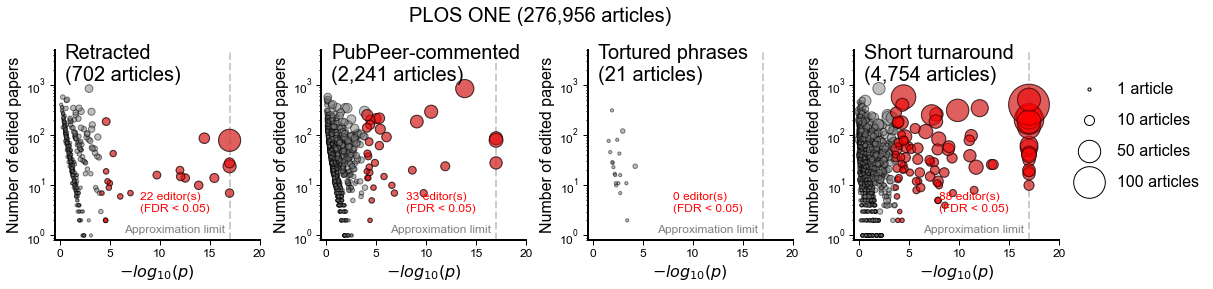

In [4]:
aff_df = []
type_df = []
date_df = []
contrib_df = []
subj_df = []

for n in list(range(1_000, 346_000, 1_000)) + [345_710]:
    contrib_df.append(pd.read_csv('../data/231109_plos_contributors_' + str(n) + '.csv'))
    type_df.append(pd.read_csv('../data/231109_plos_content_type_' + str(n) + '.csv'))
    date_df.append(pd.read_csv('../data/231109_plos_handling_time_' + str(n) + '.csv'))
    try:
        aff_df.append(pd.read_csv('../data/231109_plos_aff_' + str(n) + '.csv'))
    except:
        print('No aff_df at ' + str(n))
    subj_df.append(pd.read_csv('../data/231109_plos_subj_' + str(n) + '.csv'))

subj_df = pd.concat(subj_df).reset_index(drop=True)
contrib_df = pd.concat(contrib_df).reset_index(drop=True)
type_df = pd.concat(type_df).reset_index(drop=True)
date_df = pd.concat(date_df).reset_index(drop=True)
aff_df = pd.concat(aff_df).reset_index(drop=True)

type_df = type_df.drop_duplicates()

acceptable_types = ['Research Article', 'Review', 'Study Protocol', 
                    'Registered Report Protocol', 'Clinical Trial', 
                    'Lab Protocol', 'Collection Review']

type_df = type_df[type_df['content_type'].isin(acceptable_types)]
type_df['journal'] = type_df['doi'].apply(lambda x: x.split('.')[:-1][-1])
type_df = type_df[type_df['journal'] == 'pone']
accept_dois = type_df['doi'].values

contrib_df = contrib_df[contrib_df['doi'].isin(accept_dois)]
contrib_df = contrib_df.sort_values('orcid').drop_duplicates(subset=['doi', 'contrib', 'contrib_type', 'orcid'])
authors_df = contrib_df[contrib_df['contrib_type'] == 'author'].copy()
editors_df = contrib_df[contrib_df['contrib_type'].isin(['editor'])].copy()

editors_df = editors_df.drop_duplicates('doi', keep='first')[['doi', 'contrib', 'contrib_type']].rename(columns={'contrib':'full_name'})

authors_df['orcid'] = authors_df['orcid'].astype(str).apply(lambda x: x.split('/')[-1].strip())

date_df['date'] = pd.to_datetime(date_df['day'].astype(str) + '-' + date_df['month'].astype(str) + '-' + date_df['year'].astype(str), 
               dayfirst=True, errors='coerce')
date_df = date_df.sort_values('date').drop_duplicates(['doi', 'date_type'])\
.pivot(index='doi', columns='date_type', values='date').reset_index()
date_df['days'] = [x.days for x in (date_df['accepted'] - date_df['received'])]
date_df['year'] = [x.year for x in date_df['Published']]
short_time_dois = date_df[date_df['days'] <= 30]['doi'].values

master_authors_df = authors_df.copy()
master_authors_df['orcid'] = master_authors_df['orcid'].replace('nan', np.nan)
editors_df = pd.merge(editors_df, date_df[['doi', 'year']])
master_authors_df = pd.merge(master_authors_df, date_df[['doi', 'year']])

# Retractions
rw_db = pd.read_csv('../data/240304_retraction_watch_db.csv', encoding='latin')
a = rw_db[rw_db['RetractionNature'] == 'Retraction']['OriginalPaperDOI'].values
a = [str(x).lower() for x in a]
#a = rw_db['OriginalPaperDOI'].values

# Pubpeer
pubpeer_df = pd.read_csv('C:/Users/richa/OneDrive - Northwestern University/pubpeer_comments_20240201.csv')
pubpeer_df['id'] = pubpeer_df['ids'].astype(str).apply(lambda x: x.split(','))
pubpeer_df = pubpeer_df.explode('id')
pubpeer_df['paper_link'] = pubpeer_df['Pubpeer Link'].astype(str).apply(lambda x: '/'.join(x.split('/')[:-1])).values
b = pubpeer_df['id'].values

# Tortured Phrases
tort_df = pd.read_csv('../data/240321_tortured_phrases.csv')

editors_df['retracted'] = editors_df['doi'].isin(a)
editors_df['pubpeer'] = editors_df['doi'].isin(b)
editors_df['either'] = editors_df['retracted'] | editors_df['pubpeer']
editors_df['tortured'] = editors_df['doi'].isin(tort_df['DOI'].str.lower().values)
editors_df['short'] = editors_df['doi'].isin(short_time_dois)
editors_df['total'] = True


editors_df['full_name'] = editors_df['full_name'].str.replace('.', '').str.replace(' ', '').str.lower()

master_editors_df = editors_df.copy()

for source_id in ['pone']:
    editors_df = master_editors_df[master_editors_df['doi'].isin(accept_dois)]


    # In[17]:


    rate_df = editors_df.groupby('year').sum()[['retracted', 'pubpeer', 'either', 'tortured', 'short', 'total']]

    rate_df['p_retracted'] = rate_df['retracted']/rate_df['total']
    rate_df['p_pubpeer'] = rate_df['pubpeer']/rate_df['total']
    rate_df['p_tortured'] = rate_df['tortured']/rate_df['total']
    rate_df['p_either'] = rate_df['either']/rate_df['total']
    rate_df['p_short'] = rate_df['short']/rate_df['total']


    # In[18]:


    summary_by_editor = editors_df.groupby('full_name').sum()


    # In[19]:


    editor_year_list = editors_df.groupby('full_name')['year'].apply(list)

    rate_dict = rate_df['p_retracted'].to_dict()
    p_val_array = []
    editor_list = []
    for editor, row in tqdm(pd.DataFrame(editor_year_list).iterrows(), total=len(editor_year_list)):
        year_list = row['year']
        p_array = [rate_dict.get(x) for x in year_list]
        p_val = PoiBin(p_array).pval(int(summary_by_editor.loc[editor]['retracted']))
        editor_list.append(editor)
        p_val_array.append(p_val)

    p_val_df = pd.DataFrame({'editor':editor_list, 'retract_p_val':p_val_array})

    rate_dict = rate_df['p_pubpeer'].to_dict()
    p_val_array = []
    editor_list = []
    for editor, row in tqdm(pd.DataFrame(editor_year_list).iterrows(), total=len(editor_year_list)):
        year_list = row['year']
        p_array = [rate_dict.get(x) for x in year_list]
        p_val = PoiBin(p_array).pval(int(summary_by_editor.loc[editor]['pubpeer']))
        editor_list.append(editor)
        p_val_array.append(p_val)

    p_val_df['pubpeer_p_val'] = p_val_array

    rate_dict = rate_df['p_either'].to_dict()
    p_val_array = []
    editor_list = []
    for editor, row in tqdm(pd.DataFrame(editor_year_list).iterrows(), total=len(editor_year_list)):
        year_list = row['year']
        p_array = [rate_dict.get(x) for x in year_list]
        p_val = PoiBin(p_array).pval(int(summary_by_editor.loc[editor]['either']))
        editor_list.append(editor)
        p_val_array.append(p_val)

    p_val_df['either_p_val'] = p_val_array
    
    rate_dict = rate_df['p_tortured'].to_dict()
    p_val_array = []
    editor_list = []
    for editor, row in tqdm(pd.DataFrame(editor_year_list).iterrows(), total=len(editor_year_list)):
        year_list = row['year']
        p_array = [rate_dict.get(x) for x in year_list]
        p_val = PoiBin(p_array).pval(int(summary_by_editor.loc[editor]['tortured']))
        editor_list.append(editor)
        p_val_array.append(p_val)

    p_val_df['tortured_p_val'] = p_val_array

    rate_dict = rate_df['p_short'].to_dict()
    p_val_array = []
    editor_list = []
    for editor, row in tqdm(pd.DataFrame(editor_year_list).iterrows(), total=len(editor_year_list)):
        year_list = row['year']
        p_array = [rate_dict.get(x) for x in year_list]
        p_val = PoiBin(p_array).pval(int(summary_by_editor.loc[editor]['short']))
        editor_list.append(editor)
        p_val_array.append(p_val)

    p_val_df['short_p_val'] = p_val_array

    for col in ['retract_p_val', 'pubpeer_p_val', 'either_p_val', 'tortured_p_val', 'short_p_val']:
        p_val_df.loc[p_val_df[col] < 0, col] = 1e-17
        p_val_df[col.split('_')[0]+'_q_val'] = multipletests(p_val_df[col], method='fdr_bh')[1]
        p_val_df[col.split('_')[0]+'_fwer'] = multipletests(p_val_df[col], method='bonferroni')[1]

    p_val_df = pd.merge(p_val_df, summary_by_editor.reset_index().rename(columns={'full_name':'editor'}))

    fig, axes = plt.subplots(ncols=4, nrows=1, figsize=(18,3.5), gridspec_kw={'wspace':0.3})

    # Retractions
    ax = axes[0]
    ax.scatter(-np.log10(p_val_df['retract_p_val']), p_val_df['total'],
               color='gray', linewidth=1, alpha=0.5, s=10*p_val_df['retracted'], edgecolor='k')
    p_val_df_slice = p_val_df[p_val_df['retract_q_val'] < 0.05].copy()
    ax.scatter(-np.log10(p_val_df_slice['retract_p_val']), p_val_df_slice['total'], 
               color='r', linewidth=1, alpha=0.5, s=10*p_val_df_slice['retracted'], edgecolor='k')
    ax.set_title('Retracted\n(' + '{:,}'.format(editors_df['retracted'].sum()) + ' articles)', 
                 fontsize=20, ha='left', x=0.05, y=1.0, va='top')
    ax.text(s=str(len(p_val_df_slice)) + ' editor(s)\n(FDR < 0.05)', fontsize=12, y=3, x=8, color='r')

    # PubPeer
    ax = axes[1]
    ax.scatter(-np.log10(p_val_df['pubpeer_p_val']), p_val_df['total'],
               color='gray', linewidth=1, alpha=0.5, s=10*p_val_df['pubpeer'], edgecolor='k')
    p_val_df_slice = p_val_df[p_val_df['pubpeer_q_val'] < 0.05]
    ax.scatter(-np.log10(p_val_df_slice['pubpeer_p_val']), p_val_df_slice['total'], 
               color='r', linewidth=1, alpha=0.5, s=10*p_val_df_slice['pubpeer'], edgecolor='k')
    ax.set_title('PubPeer-commented\n(' + '{:,}'.format(editors_df['pubpeer'].sum()) + ' articles)', 
                 fontsize=20, ha='left', x=0.05, y=1.0, va='top')
    ax.text(s=str(len(p_val_df_slice)) + ' editor(s)\n(FDR < 0.05)', fontsize=12, y=3, x=8, color='r')

    # Tortured
    ax = axes[2]
    ax.scatter(-np.log10(p_val_df['tortured_p_val']), p_val_df['total'],
               color='gray', linewidth=1, alpha=0.5, s=10*p_val_df['tortured'], edgecolor='k')
    p_val_df_slice = p_val_df[p_val_df['tortured_q_val'] < 0.05]
    ax.scatter(-np.log10(p_val_df_slice['tortured_p_val']), p_val_df_slice['total'],
               color='r', linewidth=1, alpha=0.5, s=10*p_val_df_slice['tortured'], edgecolor='k')
    ax.set_title('Tortured phrases\n(' + '{:,}'.format(editors_df['tortured'].sum()) + ' articles)', 
                 fontsize=20, ha='left', x=0.05, y=1.0, va='top')
    ax.text(s=str(len(p_val_df_slice)) + ' editor(s)\n(FDR < 0.05)', fontsize=12, y=3, x=8, color='r')
    
    # Short
    ax = axes[3]
    ax.scatter(-np.log10(p_val_df['short_p_val']), p_val_df['total'],
               color='gray', linewidth=1, alpha=0.5, s=10*p_val_df['short'], edgecolor='k')
    p_val_df_slice = p_val_df[p_val_df['short_q_val'] < 0.05]
    ax.scatter(-np.log10(p_val_df_slice['short_p_val']), p_val_df_slice['total'],
               color='r', linewidth=1, alpha=0.5, s=10*p_val_df_slice['short'], edgecolor='k')
    ax.set_title('Short turnaround\n(' + '{:,}'.format(editors_df['short'].sum()) + ' articles)', 
                 fontsize=20, ha='left', x=0.05, y=1.0, va='top')
    ax.text(s=str(len(p_val_df_slice)) + ' editor(s)\n(FDR < 0.05)', fontsize=12, y=3, x=8, color='r')

    ax.scatter([], [], s=10, color='w', alpha=1, linewidth=1, edgecolor='k', label='1 article')
    ax.scatter([], [], s=100, color='w', alpha=1, linewidth=1, edgecolor='k', label='10 articles')
    ax.scatter([], [], s=500, color='w', alpha=1, linewidth=1, edgecolor='k', label='50 articles')
    ax.scatter([], [], s=1000, color='w', alpha=1, linewidth=1, edgecolor='k', label='100 articles')
    #ax.scatter([], [], s=2000, color='w', alpha=1, linewidth=1, edgecolor='k', label='200 retracted/commented')
    ax.legend(fontsize=16, bbox_to_anchor=(1,0.55), loc='center left', frameon=False, labelspacing=1, handletextpad=0.75)

    for ax in axes:
        ax.set_yscale('log')
        ax.set_xlabel(r'$-log_{10}(p)$', fontsize=16)
        ax.set_ylabel('Number of edited papers', fontsize=16)
        ax.set_ylim([0.8, 5000])
        ax.set_xlim([-0.5,20])
        ax.tick_params(width=1, length=5, which='major')
        ax.tick_params(width=1, length=2, which='minor')
        ax.tick_params(labelsize=12)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        [ax.spines[i].set_linewidth(2) for i in ax.spines]
        ax.axvline(17, color='k', linewidth=2, linestyle='dashed', alpha=0.2, zorder=-10)
        ax.text(s='Approximation limit', x=16.5, y=1, fontsize=12, va='bottom', ha='right', color='k', alpha=0.5)
    
    title = 'PLOS ONE'
        
    fig.suptitle(title + ' (' + '{:,}'.format(len(editors_df)) + ' articles)', y=1.05, fontsize=20)
    fig.savefig('../img/240405_' + source_id + '_p_value_axis_flip.png', dpi=200, bbox_inches='tight')
    p_val_df.to_csv('../data/240405_' + source_id + '_editor_p_values.csv', index=False)
    
    # author attributes
    authors_df = master_authors_df[master_authors_df['doi'].isin(editors_df['doi'])]
    
    print('{:.2f}'.format(100*authors_df['orcid'].isna().mean()) + '% of authors have no ORCID')
    print('{:.2f}'.format(100-(100*authors_df[~authors_df['orcid'].isna()]['doi'].nunique()/authors_df['doi'].nunique())) + '% of articles have no author ORCID')
    
    
    
    #### authors with preferences towards suspect editors
    for col in ['retract', 'pubpeer', 'either', 'tortured', 'short']:
        editors_df[col + '_suspect'] = editors_df['full_name'].isin(p_val_df[p_val_df[col + '_fwer'] < 0.05]['editor'])

    rate_df = editors_df.groupby('year').sum()[['retract_suspect', 'pubpeer_suspect', 'either_suspect', 'tortured_suspect', 'short_suspect', 'total']]

    rate_df['p_retract_suspect'] = rate_df['retract_suspect']/rate_df['total']
    rate_df['p_pubpeer_suspect'] = rate_df['pubpeer_suspect']/rate_df['total']
    rate_df['p_either_suspect'] = rate_df['either_suspect']/rate_df['total']
    rate_df['p_tortured_suspect'] = rate_df['tortured_suspect']/rate_df['total']
    rate_df['p_short_suspect'] = rate_df['short_suspect']/rate_df['total']

    ###### By ORCID ID
    summary_by_author = pd.merge(master_authors_df, editors_df, on='doi').dropna(subset=['orcid']).groupby('orcid').sum()

    author_year_list = authors_df.dropna(subset=['orcid']).groupby('orcid')['year'].apply(list)

    rate_dict = rate_df['p_retract_suspect'].to_dict()
    p_val_array = []
    author_list = []
    for author, row in tqdm(pd.DataFrame(author_year_list).iterrows(), total=len(author_year_list)):
        year_list = row['year']
        p_array = [rate_dict.get(x) for x in year_list]
        p_val = PoiBin(p_array).pval(int(summary_by_author.loc[author]['retract_suspect']))
        author_list.append(author)
        p_val_array.append(p_val)

    author_p_val_df = pd.DataFrame({'author':author_list, 'retract_suspect_p_val':p_val_array})

    rate_dict = rate_df['p_pubpeer_suspect'].to_dict()
    p_val_array = []
    author_list = []
    for author, row in tqdm(pd.DataFrame(author_year_list).iterrows(), total=len(author_year_list)):
        year_list = row['year']
        p_array = [rate_dict.get(x) for x in year_list]
        p_val = PoiBin(p_array).pval(int(summary_by_author.loc[author]['pubpeer_suspect']))
        author_list.append(author)
        p_val_array.append(p_val)

    author_p_val_df['pubpeer_suspect_p_val'] = p_val_array

    rate_dict = rate_df['p_tortured_suspect'].to_dict()
    p_val_array = []
    author_list = []
    for author, row in tqdm(pd.DataFrame(author_year_list).iterrows(), total=len(author_year_list)):
        year_list = row['year']
        p_array = [rate_dict.get(x) for x in year_list]
        p_val = PoiBin(p_array).pval(int(summary_by_author.loc[author]['tortured_suspect']))
        author_list.append(author)
        p_val_array.append(p_val)

    author_p_val_df['tortured_suspect_p_val'] = p_val_array

    rate_dict = rate_df['p_short_suspect'].to_dict()
    p_val_array = []
    author_list = []
    for author, row in tqdm(pd.DataFrame(author_year_list).iterrows(), total=len(author_year_list)):
        year_list = row['year']
        p_array = [rate_dict.get(x) for x in year_list]
        p_val = PoiBin(p_array).pval(int(summary_by_author.loc[author]['short_suspect']))
        author_list.append(author)
        p_val_array.append(p_val)

    author_p_val_df['short_suspect_p_val'] = p_val_array

    rate_dict = rate_df['p_either_suspect'].to_dict()
    p_val_array = []
    editor_list = []
    for author, row in tqdm(pd.DataFrame(author_year_list).iterrows(), total=len(author_year_list)):
        year_list = row['year']
        p_array = [rate_dict.get(x) for x in year_list]
        p_val = PoiBin(p_array).pval(int(summary_by_author.loc[author]['either_suspect']))
        editor_list.append(editor)
        p_val_array.append(p_val)

    author_p_val_df['either_suspect_p_val'] = p_val_array

    for col in ['retract_suspect_p_val', 'pubpeer_suspect_p_val', 'either_suspect_p_val', 'tortured_suspect_p_val', 'short_suspect_p_val']:
        author_p_val_df.loc[author_p_val_df[col] < 0, col] = 1e-17
        author_p_val_df[col.split('_')[0]+'_' + col.split('_')[1] + '_q_val'] = multipletests(author_p_val_df[col], method='fdr_bh')[1]
        author_p_val_df[col.split('_')[0]+'_' + col.split('_')[1] + '_fwer'] = multipletests(author_p_val_df[col], method='bonferroni')[1]

    author_p_val_df = pd.merge(author_p_val_df, summary_by_author.reset_index().rename(columns={'orcid':'author'}))
    author_p_val_df.to_csv('../data/240405_' + source_id + '_author_orcid_p_values_fwer.csv', index=False)

In [1]:
acceptable_types = ['Research Article', 'Review', 'Study Protocol', 
                    'Registered Report Protocol', 'Clinical Trial', 
                    'Lab Protocol', 'Collection Review']

for type_a in acceptable_types:
    print(type_a)

Research Article
Review
Study Protocol
Registered Report Protocol
Clinical Trial
Lab Protocol
Collection Review


In [5]:
author_p_val_df_array = []
for source_id in ['pone']:
    try:
        author_p_val_df = pd.read_csv('../data/240405_' + source_id + '_author_orcid_p_values.csv')
        author_p_val_df['source_id'] = source_id
        author_p_val_df_array.append(author_p_val_df)
    except:
        pass
author_p_val_df = pd.concat(author_p_val_df_array)

In [11]:
def get_date_count_df(editors_df, date_df, editors_of_interest):   
    editor_date_df = pd.merge(editors_df, date_df[['doi', 'received', 'accepted']])
    editor_date_df = editor_date_df[editor_date_df['full_name'].isin(editors_of_interest)]
    received_df = editor_date_df.sort_values(['received'], ascending=True).drop_duplicates(['full_name'], keep='first')
    accepted_df = editor_date_df.sort_values(['accepted'], ascending=False).drop_duplicates(['full_name'], keep='first')
    received_df = received_df[['full_name', 'received']].rename(columns={'received':'date'})
    received_df['type'] = 'received'
    accepted_df = accepted_df[['full_name', 'accepted']].rename(columns={'accepted':'date'})
    accepted_df['type'] = 'accepted'
    editor_date_df = pd.concat([received_df, accepted_df]).sort_values('date')

    count = 0
    date_count_array = []
    for index, row in editor_date_df.iterrows():
        date_count_array.append(pd.DataFrame({'date':[row['date']], 'count':[count]}))
        if row['type'] == 'received':
            count += 1
        else:
            count -= 1
        date_count_array.append(pd.DataFrame({'date':[row['date']], 'count':[count]}))
    if len(date_count_array) > 0:
        date_count_df = pd.concat(date_count_array)
        date_count_df['origin'] = 0
    else:
        date_count_df = pd.DataFrame({'date':[pd.to_datetime('Jan 1, 2020')], 'count':[0], 'origin':[0]})
    return date_count_df

# With FWER (Figure S2)

In [1]:
%%time

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(16,13), gridspec_kw={'hspace':0.2, 'wspace':0.35})

source_id = 'pone'

### first column: counts
year_series = editors_df.groupby('year').sum()
ax = axes[0][0]
ax.bar(x=year_series.index+0.5, height=year_series['total'], color='gray')
ax.set_title('Total\n(' + '{:,}'.format(editors_df['total'].sum()) + ' articles)', 
                 fontsize=16, ha='left', x=0.05, y=0.95, va='top')

ax = axes[1][0]
ax.bar(x=year_series.index+0.5, height=year_series['retracted'], color='r')
ax.set_title('Retracted\n(' + '{:,}'.format(editors_df['retracted'].sum()) + ' articles)', 
                 fontsize=16, ha='left', x=0.05, y=0.95, va='top')


ax = axes[2][0]
ax.bar(x=year_series.index+0.5, height=year_series['pubpeer'], color='b')
ax.set_title('PubPeer-commented\n(' + '{:,}'.format(editors_df['pubpeer'].sum()) + ' articles)', 
                 fontsize=16, ha='left', x=0.05, y=0.95, va='top')

ax = axes[3][0]
ax.bar(x=year_series.index+0.5, height=year_series['short'], color='g')
ax.set_title('Short turnaround\n(' + '{:,}'.format(editors_df['short'].sum()) + ' articles)', 
                 fontsize=16, ha='left', x=0.05, y=0.95, va='top')

for ax in axes[:,0]:
    ax.set_ylim(bottom=0, top=ax.get_ylim()[1]*1.3)
    ax.set_xlim([2006-0.2,2024])
    ax.tick_params(width=1, length=5, which='major')
    ax.tick_params(width=1, length=2, which='minor')
    ax.tick_params(labelsize=12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    [ax.spines[i].set_linewidth(2) for i in ax.spines]
    ax.get_yaxis().set_major_formatter(
        mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    ax.set_ylabel('Number of articles', fontsize=14)
axes[3][0].set_xlabel('Publication year', fontsize=14)

    
### third column: editor enrichments
p_val_df = pd.read_csv('../data/240405_' + source_id + '_editor_p_values.csv')

# Retractions
ax = axes[1][2]
ax.scatter(-np.log10(p_val_df['retract_p_val']), p_val_df['total'],
               color='gray', linewidth=1, alpha=0.5, s=10*p_val_df['retracted'], edgecolor='k')
p_val_df_slice = p_val_df[p_val_df['retract_fwer'] < 0.05].copy()
ax.scatter(-np.log10(p_val_df_slice['retract_p_val']), p_val_df_slice['total'], 
               color='r', linewidth=1, alpha=0.5, s=10*p_val_df_slice['retracted'], edgecolor='k')
ax.set_title('Retracted\n(' + str(len(p_val_df_slice)) + ' editors flagged,\nFWER < 0.05)', 
                 fontsize=14, ha='left', x=0.05, y=0.95, va='top')

# PubPeer
ax = axes[2][2]
ax.scatter(-np.log10(p_val_df['pubpeer_p_val']), p_val_df['total'],
               color='gray', linewidth=1, alpha=0.5, s=10*p_val_df['pubpeer'], edgecolor='k')
p_val_df_slice = p_val_df[p_val_df['pubpeer_fwer'] < 0.05]
ax.scatter(-np.log10(p_val_df_slice['pubpeer_p_val']), p_val_df_slice['total'], 
               color='b', linewidth=1, alpha=0.5, s=10*p_val_df_slice['pubpeer'], edgecolor='k')
ax.set_title('PubPeer-commented\n(' + str(len(p_val_df_slice)) + ' editors flagged,\nFWER < 0.05)', 
                 fontsize=14, ha='left', x=0.05, y=0.95, va='top')
    
# Short
ax = axes[3][2]
ax.scatter(-np.log10(p_val_df['short_p_val']), p_val_df['total'],
               color='gray', linewidth=1, alpha=0.5, s=10*p_val_df['short'], edgecolor='k')
p_val_df_slice = p_val_df[p_val_df['short_fwer'] < 0.05]
ax.scatter(-np.log10(p_val_df_slice['short_p_val']), p_val_df_slice['total'],
               color='g', linewidth=1, alpha=0.5, s=10*p_val_df_slice['short'], edgecolor='k')
ax.set_title('Short turnaround\n(' + str(len(p_val_df_slice)) + ' editors flagged,\nFWER < 0.05)', 
                 fontsize=14, ha='left', x=0.05, y=0.95, va='top')
ax.set_xlabel(r'$-log_{10}(p)$', fontsize=14)

# legend
ax = axes[0][2]
ax.scatter([], [], s=10, color='w', alpha=1, linewidth=1, edgecolor='k', label='1 article')
ax.scatter([], [], s=100, color='w', alpha=1, linewidth=1, edgecolor='k', label='10 articles')
ax.scatter([], [], s=500, color='w', alpha=1, linewidth=1, edgecolor='k', label='50 articles')
ax.scatter([], [], s=1000, color='w', alpha=1, linewidth=1, edgecolor='k', label='100 articles')
#ax.scatter([], [], s=2000, color='w', alpha=1, linewidth=1, edgecolor='k', label='200 retracted/commented')
leg = ax.legend(fontsize=16, bbox_to_anchor=(-0.1,0.5), 
              loc='center left', frameon=False, labelspacing=1, handletextpad=0.75)
leg.set_title('Number of flagged\narticles')
plt.setp(leg.get_title(),fontsize=16, ha='left')
leg._legend_box.align = 'left'
ax.axis('off')

for ax in axes[1:,2]:
    ax.set_yscale('log')
    #ax.set_xlabel(r'$-log_{10}(p)$', fontsize=14)
    ax.set_ylabel('Number of edited papers', fontsize=14)
    ax.set_ylim([0.8, 40_000])
    ax.set_xlim([-0.5,20])
    ax.tick_params(width=1, length=5, which='major')
    ax.tick_params(width=1, length=2, which='minor')
    ax.tick_params(labelsize=12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    [ax.spines[i].set_linewidth(2) for i in ax.spines]
    ax.axvline(17, color='k', linewidth=2, linestyle='dashed', alpha=0.2, zorder=-10)
    ax.text(s='Approximation limit', x=16.5, y=1, fontsize=8, va='bottom', ha='right', color='k', alpha=0.5)
    
### second column: editor tenures

# all editors
ax = axes[0][1]
editors_of_interest = p_val_df['editor'].values
date_count_df = get_date_count_df(editors_df, date_df, editors_of_interest)
ax.fill_between(x=date_count_df['date'], 
                     y1=date_count_df['count'], 
                     y2=date_count_df['origin'], linewidth=0, color='gray')
ax.set_title('All editors\n' + '({:,} editors)'.format(len(editors_of_interest)),
                 fontsize=14, ha='left', x=0.05, y=0.95, va='top')
if date_count_df['count'].max() < 4:
    ax.set_yticks(np.arange(0, date_count_df['count'].max()+1))

# retracted
ax = axes[1][1]
editors_of_interest = p_val_df[p_val_df['retract_fwer'] < 0.05]['editor'].values
date_count_df = get_date_count_df(editors_df, date_df, editors_of_interest)
ax.fill_between(x=date_count_df['date'], 
                     y1=date_count_df['count'], 
                     y2=date_count_df['origin'], linewidth=0, color='r')
ax.set_title('Editors flagged\nfor retractions\n' + '({:,} editors)'.format(len(editors_of_interest)), 
                 fontsize=14, ha='left', x=0.05, y=0.95, va='top')
if date_count_df['count'].max() < 4:
    ax.set_yticks(np.arange(0, date_count_df['count'].max()+1))

# pubpeer
ax = axes[2][1]
editors_of_interest = p_val_df[p_val_df['pubpeer_fwer'] < 0.05]['editor'].values
date_count_df = get_date_count_df(editors_df, date_df, editors_of_interest)
ax.fill_between(x=date_count_df['date'], 
                     y1=date_count_df['count'], 
                     y2=date_count_df['origin'], linewidth=0, color='b')
ax.set_title('Editors flagged\nfor PubPeer comments\n' + '({:,} editors)'.format(len(editors_of_interest)), 
                 fontsize=14, ha='left', x=0.05, y=0.95, va='top')
if date_count_df['count'].max() < 4:
    ax.set_yticks(np.arange(0, date_count_df['count'].max()+1))

# turnaround
ax = axes[3][1]
editors_of_interest = p_val_df[p_val_df['short_fwer'] < 0.05]['editor'].values
date_count_df = get_date_count_df(editors_df, date_df, editors_of_interest)
ax.fill_between(x=date_count_df['date'], 
                     y1=date_count_df['count'], 
                     y2=date_count_df['origin'], linewidth=0, color='g')
ax.set_title('Editors flagged\nfor short turnaround\n' + '({:,} editors)'.format(len(editors_of_interest)),
                 fontsize=14, ha='left', x=0.05, y=0.95, va='top')
if date_count_df['count'].max() < 4:
    ax.set_yticks(np.arange(0, date_count_df['count'].max()+1))
axes[3][1].set_xlabel('Date', fontsize=14)


for ax in axes[:,1]:
    ax.set_ylim(bottom=0)
    ax.set_xlim([pd.to_datetime('Jan 1, 2006'), pd.to_datetime('Jan 1, 2024')])
    ax.set_xticks([pd.to_datetime('Jan 1, 2010'), pd.to_datetime('Jan 1, 2020')])
    ax.tick_params(width=1, length=5, which='major')
    ax.tick_params(width=1, length=2, which='minor')
    ax.tick_params(labelsize=12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylabel('Number of active editors', fontsize=14)
    [ax.spines[i].set_linewidth(2) for i in ax.spines]
    ax.set_ylim(bottom=0, top=ax.get_ylim()[1]*1.4)
    if ax.get_ylim()[1] < 20:
        ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    ax.get_yaxis().set_major_formatter(
            mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    myFmt = mpl.dates.DateFormatter('%Y')
    ax.xaxis.set_major_formatter(myFmt)
    
### fourth column: authors enrichment for editors

# This variable would have contained a list of flagged author ORCiDs that also
# turned out to be editors at PLOS One, compiled through manual inspection. It
# has been removed here.
# editor_orcids = []

p_val_df = pd.read_csv('../data/240405_' + source_id + '_author_orcid_p_values_fwer.csv')

# Retractions
ax = axes[1][3]
ax.scatter(-np.log10(p_val_df['retract_suspect_p_val']), p_val_df['total'],
               color='gray', linewidth=1, alpha=0.5, s=10*p_val_df['retract_suspect'], edgecolor='k')
p_val_df_slice = p_val_df[p_val_df['retract_suspect_fwer'] < 0.05].copy()
ax.scatter(-np.log10(p_val_df_slice['retract_suspect_p_val']), p_val_df_slice['total'], 
               color='r', linewidth=1, alpha=0.5, s=10*p_val_df_slice['retract_suspect'], edgecolor='k')
ax.set_title('Pref. for editors flagged\nfor retractions\n(' + str(len(p_val_df_slice)) + ' authors flagged,\nFWER < 0.05)', 
                 fontsize=14, ha='left', x=0.05, y=0.95, va='top')
#p_val_df_slice = p_val_df_slice[p_val_df_slice['author'].isin(editor_orcids)].copy()

# PubPeer
ax = axes[2][3]
ax.scatter(-np.log10(p_val_df['pubpeer_suspect_p_val']), p_val_df['total'],
               color='gray', linewidth=1, alpha=0.5, s=10*p_val_df['pubpeer_suspect'], edgecolor='k')
p_val_df_slice = p_val_df[p_val_df['pubpeer_suspect_fwer'] < 0.05]
ax.scatter(-np.log10(p_val_df_slice['pubpeer_suspect_p_val']), p_val_df_slice['total'], 
               color='b', linewidth=1, alpha=0.5, s=10*p_val_df_slice['pubpeer_suspect'], edgecolor='k')
ax.set_title('Pref. for editors flagged\nfor PubPeer comments\n(' + str(len(p_val_df_slice)) + ' authors flagged,\nFWER < 0.05)', 
                 fontsize=14, ha='left', x=0.05, y=0.95, va='top')
#p_val_df_slice = p_val_df_slice[p_val_df_slice['author'].isin(editor_orcids)].copy()

    
# Short
ax = axes[3][3]
ax.scatter(-np.log10(p_val_df['short_suspect_p_val']), p_val_df['total'],
               color='gray', linewidth=1, alpha=0.5, s=10*p_val_df['short'], edgecolor='k')
p_val_df_slice = p_val_df[p_val_df['short_suspect_fwer'] < 0.05]
ax.scatter(-np.log10(p_val_df_slice['short_suspect_p_val']), p_val_df_slice['total'],
               color='g', linewidth=1, alpha=0.5, s=10*p_val_df_slice['short_suspect'], edgecolor='k')
ax.set_title('Pref. for editors flagged\nfor short turnaround\n(' + str(len(p_val_df_slice)) + ' authors flagged,\nFWER < 0.05)', 
                 fontsize=14, ha='left', x=0.05, y=0.95, va='top')
#p_val_df_slice = p_val_df_slice[p_val_df_slice['author'].isin(editor_orcids)].copy()

ax.set_xlabel(r'$-log_{10}(p)$', fontsize=14)

# legend
ax = axes[0][3]
ax.scatter([], [], s=10, color='w', alpha=1, linewidth=1, edgecolor='k', label='1 article')
ax.scatter([], [], s=50, color='w', alpha=1, linewidth=1, edgecolor='k', label='5 articles')
ax.scatter([], [], s=100, color='w', alpha=1, linewidth=1, edgecolor='k', label='10 articles')
ax.scatter([], [], s=200, color='w', alpha=1, linewidth=1, edgecolor='k', label='20 articles')
#ax.scatter([], [], s=2000, color='w', alpha=1, linewidth=1, edgecolor='k', label='200 retracted/commented')
leg = ax.legend(fontsize=16, bbox_to_anchor=(-0.1,0.5), 
              loc='center left', frameon=False, labelspacing=1, handletextpad=0.75)
leg.set_title('Number of articles\nhandled by flagged editors')
plt.setp(leg.get_title(),fontsize=16, ha='left')
leg._legend_box.align = 'left'
ax.axis('off')

for ax in axes[1:,3]:
    ax.set_yscale('log')
    #ax.set_xlabel(r'$-log_{10}(p)$', fontsize=14)
    ax.set_ylabel('Number of authored papers', fontsize=14)
    ax.set_ylim([0.8, 4_00])
    ax.set_xlim([-0.5,18])
    ax.tick_params(width=1, length=5, which='major')
    ax.tick_params(width=1, length=2, which='minor')
    ax.tick_params(labelsize=12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    [ax.spines[i].set_linewidth(2) for i in ax.spines]
    ax.axvline(17, color='k', linewidth=2, linestyle='dashed', alpha=0.2, zorder=-10)
    ax.text(s='Approximation limit', x=16.5, y=1, fontsize=8, va='bottom', ha='right', color='k', alpha=0.5)
     
fig.text(s='a', x=0.07, y=0.89, fontsize=20, weight='bold')
fig.text(s='b', x=0.3, y=0.89, fontsize=20, weight='bold')
fig.text(s='c', x=0.48, y=0.89, fontsize=20, weight='bold')
fig.text(s='d', x=0.70, y=0.89, fontsize=20, weight='bold')     
fig.savefig('../img/240411_' + source_id + '_summary_fig_fwer.png', dpi=200, bbox_inches='tight')

NameError: name 'plt' is not defined

# With FDR (Figure 1A-D)

No aff_df at 344000
No aff_df at 345710


C:\Users\richa\AppData\Local\Temp\ipykernel_29028\4219615526.py:63: DtypeWarning: Columns (1,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  pubpeer_df = pd.read_csv('C:/Users/richa/OneDrive - Northwestern University/pubpeer_comments_20240201.csv')
C:\Users\richa\AppData\Local\Temp\ipykernel_29028\4219615526.py:80: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  editors_df['full_name'] = editors_df['full_name'].str.replace('.', '').str.replace(' ', '').str.lower()


  0%|          | 0/18329 [00:00<?, ?it/s]

  0%|          | 0/18329 [00:00<?, ?it/s]

  0%|          | 0/18329 [00:00<?, ?it/s]

  0%|          | 0/18329 [00:00<?, ?it/s]

  0%|          | 0/18329 [00:00<?, ?it/s]

91.24% of authors have no ORCID
60.24% of articles have no author ORCID


  0%|          | 0/134983 [00:00<?, ?it/s]

  0%|          | 0/134983 [00:00<?, ?it/s]

  0%|          | 0/134983 [00:00<?, ?it/s]

  0%|          | 0/134983 [00:00<?, ?it/s]

  0%|          | 0/134983 [00:00<?, ?it/s]

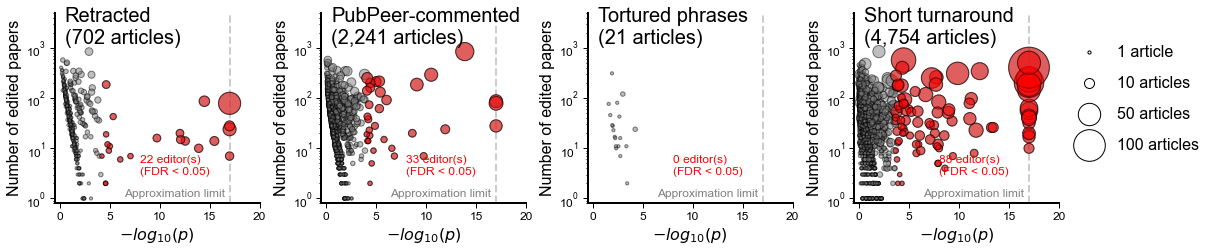

In [20]:
aff_df = []
type_df = []
date_df = []
contrib_df = []
subj_df = []

for n in list(range(1_000, 346_000, 1_000)) + [345_710]:
    contrib_df.append(pd.read_csv('../data/231109_plos_contributors_' + str(n) + '.csv'))
    type_df.append(pd.read_csv('../data/231109_plos_content_type_' + str(n) + '.csv'))
    date_df.append(pd.read_csv('../data/231109_plos_handling_time_' + str(n) + '.csv'))
    try:
        aff_df.append(pd.read_csv('../data/231109_plos_aff_' + str(n) + '.csv'))
    except:
        print('No aff_df at ' + str(n))
    subj_df.append(pd.read_csv('../data/231109_plos_subj_' + str(n) + '.csv'))

subj_df = pd.concat(subj_df).reset_index(drop=True)
contrib_df = pd.concat(contrib_df).reset_index(drop=True)
type_df = pd.concat(type_df).reset_index(drop=True)
date_df = pd.concat(date_df).reset_index(drop=True)
aff_df = pd.concat(aff_df).reset_index(drop=True)

type_df = type_df.drop_duplicates()

acceptable_types = ['Research Article', 'Review', 'Study Protocol', 
                    'Registered Report Protocol', 'Clinical Trial', 
                    'Lab Protocol', 'Collection Review']

type_df = type_df[type_df['content_type'].isin(acceptable_types)]
type_df['journal'] = type_df['doi'].apply(lambda x: x.split('.')[:-1][-1])
type_df = type_df[type_df['journal'] == 'pone']
accept_dois = type_df['doi'].values

contrib_df = contrib_df[contrib_df['doi'].isin(accept_dois)]
contrib_df = contrib_df.sort_values('orcid').drop_duplicates(subset=['doi', 'contrib', 'contrib_type', 'orcid'])
authors_df = contrib_df[contrib_df['contrib_type'] == 'author'].copy()
editors_df = contrib_df[contrib_df['contrib_type'].isin(['editor'])].copy()

editors_df = editors_df.drop_duplicates('doi', keep='first')[['doi', 'contrib', 'contrib_type']].rename(columns={'contrib':'full_name'})

authors_df['orcid'] = authors_df['orcid'].astype(str).apply(lambda x: x.split('/')[-1].strip())

date_df['date'] = pd.to_datetime(date_df['day'].astype(str) + '-' + date_df['month'].astype(str) + '-' + date_df['year'].astype(str), 
               dayfirst=True, errors='coerce')
date_df = date_df.sort_values('date').drop_duplicates(['doi', 'date_type'])\
.pivot(index='doi', columns='date_type', values='date').reset_index()
date_df['days'] = [x.days for x in (date_df['accepted'] - date_df['received'])]
date_df['year'] = [x.year for x in date_df['Published']]
short_time_dois = date_df[date_df['days'] <= 30]['doi'].values

master_authors_df = authors_df.copy()
master_authors_df['orcid'] = master_authors_df['orcid'].replace('nan', np.nan)
editors_df = pd.merge(editors_df, date_df[['doi', 'year']])
master_authors_df = pd.merge(master_authors_df, date_df[['doi', 'year']])

# Retractions
rw_db = pd.read_csv('../data/240304_retraction_watch_db.csv', encoding='latin')
a = rw_db[rw_db['RetractionNature'] == 'Retraction']['OriginalPaperDOI'].values
a = [str(x).lower() for x in a]
#a = rw_db['OriginalPaperDOI'].values

# Pubpeer
pubpeer_df = pd.read_csv('C:/Users/richa/OneDrive - Northwestern University/pubpeer_comments_20240201.csv')
pubpeer_df['id'] = pubpeer_df['ids'].astype(str).apply(lambda x: x.split(','))
pubpeer_df = pubpeer_df.explode('id')
pubpeer_df['paper_link'] = pubpeer_df['Pubpeer Link'].astype(str).apply(lambda x: '/'.join(x.split('/')[:-1])).values
b = pubpeer_df['id'].values

# Tortured Phrases
tort_df = pd.read_csv('../data/240321_tortured_phrases.csv')

editors_df['retracted'] = editors_df['doi'].isin(a)
editors_df['pubpeer'] = editors_df['doi'].isin(b)
editors_df['either'] = editors_df['retracted'] | editors_df['pubpeer']
editors_df['tortured'] = editors_df['doi'].isin(tort_df['DOI'].str.lower().values)
editors_df['short'] = editors_df['doi'].isin(short_time_dois)
editors_df['total'] = True


editors_df['full_name'] = editors_df['full_name'].str.replace('.', '').str.replace(' ', '').str.lower()

master_editors_df = editors_df.copy()

for source_id in ['pone']:
    editors_df = master_editors_df[master_editors_df['doi'].isin(accept_dois)]


    # In[17]:


    rate_df = editors_df.groupby('year').sum()[['retracted', 'pubpeer', 'either', 'tortured', 'short', 'total']]

    rate_df['p_retracted'] = rate_df['retracted']/rate_df['total']
    rate_df['p_pubpeer'] = rate_df['pubpeer']/rate_df['total']
    rate_df['p_tortured'] = rate_df['tortured']/rate_df['total']
    rate_df['p_either'] = rate_df['either']/rate_df['total']
    rate_df['p_short'] = rate_df['short']/rate_df['total']


    # In[18]:


    summary_by_editor = editors_df.groupby('full_name').sum()


    # In[19]:


    editor_year_list = editors_df.groupby('full_name')['year'].apply(list)

    rate_dict = rate_df['p_retracted'].to_dict()
    p_val_array = []
    editor_list = []
    for editor, row in tqdm(pd.DataFrame(editor_year_list).iterrows(), total=len(editor_year_list)):
        year_list = row['year']
        p_array = [rate_dict.get(x) for x in year_list]
        p_val = PoiBin(p_array).pval(int(summary_by_editor.loc[editor]['retracted']))
        editor_list.append(editor)
        p_val_array.append(p_val)

    p_val_df = pd.DataFrame({'editor':editor_list, 'retract_p_val':p_val_array})

    rate_dict = rate_df['p_pubpeer'].to_dict()
    p_val_array = []
    editor_list = []
    for editor, row in tqdm(pd.DataFrame(editor_year_list).iterrows(), total=len(editor_year_list)):
        year_list = row['year']
        p_array = [rate_dict.get(x) for x in year_list]
        p_val = PoiBin(p_array).pval(int(summary_by_editor.loc[editor]['pubpeer']))
        editor_list.append(editor)
        p_val_array.append(p_val)

    p_val_df['pubpeer_p_val'] = p_val_array

    rate_dict = rate_df['p_either'].to_dict()
    p_val_array = []
    editor_list = []
    for editor, row in tqdm(pd.DataFrame(editor_year_list).iterrows(), total=len(editor_year_list)):
        year_list = row['year']
        p_array = [rate_dict.get(x) for x in year_list]
        p_val = PoiBin(p_array).pval(int(summary_by_editor.loc[editor]['either']))
        editor_list.append(editor)
        p_val_array.append(p_val)

    p_val_df['either_p_val'] = p_val_array
    
    rate_dict = rate_df['p_tortured'].to_dict()
    p_val_array = []
    editor_list = []
    for editor, row in tqdm(pd.DataFrame(editor_year_list).iterrows(), total=len(editor_year_list)):
        year_list = row['year']
        p_array = [rate_dict.get(x) for x in year_list]
        p_val = PoiBin(p_array).pval(int(summary_by_editor.loc[editor]['tortured']))
        editor_list.append(editor)
        p_val_array.append(p_val)

    p_val_df['tortured_p_val'] = p_val_array

    rate_dict = rate_df['p_short'].to_dict()
    p_val_array = []
    editor_list = []
    for editor, row in tqdm(pd.DataFrame(editor_year_list).iterrows(), total=len(editor_year_list)):
        year_list = row['year']
        p_array = [rate_dict.get(x) for x in year_list]
        p_val = PoiBin(p_array).pval(int(summary_by_editor.loc[editor]['short']))
        editor_list.append(editor)
        p_val_array.append(p_val)

    p_val_df['short_p_val'] = p_val_array

    for col in ['retract_p_val', 'pubpeer_p_val', 'either_p_val', 'tortured_p_val', 'short_p_val']:
        p_val_df.loc[p_val_df[col] < 0, col] = 1e-17
        p_val_df[col.split('_')[0]+'_q_val'] = multipletests(p_val_df[col], method='fdr_bh')[1]
        p_val_df[col.split('_')[0]+'_fwer'] = multipletests(p_val_df[col], method='bonferroni')[1]

    p_val_df = pd.merge(p_val_df, summary_by_editor.reset_index().rename(columns={'full_name':'editor'}))

    fig, axes = plt.subplots(ncols=4, nrows=1, figsize=(18,3.5), gridspec_kw={'wspace':0.3})

    # Retractions
    ax = axes[0]
    ax.scatter(-np.log10(p_val_df['retract_p_val']), p_val_df['total'],
               color='gray', linewidth=1, alpha=0.5, s=10*p_val_df['retracted'], edgecolor='k')
    p_val_df_slice = p_val_df[p_val_df['retract_q_val'] < 0.05].copy()
    ax.scatter(-np.log10(p_val_df_slice['retract_p_val']), p_val_df_slice['total'], 
               color='r', linewidth=1, alpha=0.5, s=10*p_val_df_slice['retracted'], edgecolor='k')
    ax.set_title('Retracted\n(' + '{:,}'.format(editors_df['retracted'].sum()) + ' articles)', 
                 fontsize=20, ha='left', x=0.05, y=1.0, va='top')
    ax.text(s=str(len(p_val_df_slice)) + ' editor(s)\n(FDR < 0.05)', fontsize=12, y=3, x=8, color='r')

    # PubPeer
    ax = axes[1]
    ax.scatter(-np.log10(p_val_df['pubpeer_p_val']), p_val_df['total'],
               color='gray', linewidth=1, alpha=0.5, s=10*p_val_df['pubpeer'], edgecolor='k')
    p_val_df_slice = p_val_df[p_val_df['pubpeer_q_val'] < 0.05]
    ax.scatter(-np.log10(p_val_df_slice['pubpeer_p_val']), p_val_df_slice['total'], 
               color='r', linewidth=1, alpha=0.5, s=10*p_val_df_slice['pubpeer'], edgecolor='k')
    ax.set_title('PubPeer-commented\n(' + '{:,}'.format(editors_df['pubpeer'].sum()) + ' articles)', 
                 fontsize=20, ha='left', x=0.05, y=1.0, va='top')
    ax.text(s=str(len(p_val_df_slice)) + ' editor(s)\n(FDR < 0.05)', fontsize=12, y=3, x=8, color='r')

    # Tortured
    ax = axes[2]
    ax.scatter(-np.log10(p_val_df['tortured_p_val']), p_val_df['total'],
               color='gray', linewidth=1, alpha=0.5, s=10*p_val_df['tortured'], edgecolor='k')
    p_val_df_slice = p_val_df[p_val_df['tortured_q_val'] < 0.05]
    ax.scatter(-np.log10(p_val_df_slice['tortured_p_val']), p_val_df_slice['total'],
               color='r', linewidth=1, alpha=0.5, s=10*p_val_df_slice['tortured'], edgecolor='k')
    ax.set_title('Tortured phrases\n(' + '{:,}'.format(editors_df['tortured'].sum()) + ' articles)', 
                 fontsize=20, ha='left', x=0.05, y=1.0, va='top')
    ax.text(s=str(len(p_val_df_slice)) + ' editor(s)\n(FDR < 0.05)', fontsize=12, y=3, x=8, color='r')
    
    # Short
    ax = axes[3]
    ax.scatter(-np.log10(p_val_df['short_p_val']), p_val_df['total'],
               color='gray', linewidth=1, alpha=0.5, s=10*p_val_df['short'], edgecolor='k')
    p_val_df_slice = p_val_df[p_val_df['short_q_val'] < 0.05]
    ax.scatter(-np.log10(p_val_df_slice['short_p_val']), p_val_df_slice['total'],
               color='r', linewidth=1, alpha=0.5, s=10*p_val_df_slice['short'], edgecolor='k')
    ax.set_title('Short turnaround\n(' + '{:,}'.format(editors_df['short'].sum()) + ' articles)', 
                 fontsize=20, ha='left', x=0.05, y=1.0, va='top')
    ax.text(s=str(len(p_val_df_slice)) + ' editor(s)\n(FDR < 0.05)', fontsize=12, y=3, x=8, color='r')

    ax.scatter([], [], s=10, color='w', alpha=1, linewidth=1, edgecolor='k', label='1 article')
    ax.scatter([], [], s=100, color='w', alpha=1, linewidth=1, edgecolor='k', label='10 articles')
    ax.scatter([], [], s=500, color='w', alpha=1, linewidth=1, edgecolor='k', label='50 articles')
    ax.scatter([], [], s=1000, color='w', alpha=1, linewidth=1, edgecolor='k', label='100 articles')
    #ax.scatter([], [], s=2000, color='w', alpha=1, linewidth=1, edgecolor='k', label='200 retracted/commented')
    ax.legend(fontsize=16, bbox_to_anchor=(1,0.55), loc='center left', frameon=False, labelspacing=1, handletextpad=0.75)

    for ax in axes:
        ax.set_yscale('log')
        ax.set_xlabel(r'$-log_{10}(p)$', fontsize=16)
        ax.set_ylabel('Number of edited papers', fontsize=16)
        ax.set_ylim([0.8, 5000])
        ax.set_xlim([-0.5,20])
        ax.tick_params(width=1, length=5, which='major')
        ax.tick_params(width=1, length=2, which='minor')
        ax.tick_params(labelsize=12)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        [ax.spines[i].set_linewidth(2) for i in ax.spines]
        ax.axvline(17, color='k', linewidth=2, linestyle='dashed', alpha=0.2, zorder=-10)
        ax.text(s='Approximation limit', x=16.5, y=1, fontsize=12, va='bottom', ha='right', color='k', alpha=0.5)
    
    title = 'PLOS ONE'
        
    #fig.suptitle(title + ' (' + '{:,}'.format(len(editors_df)) + ' articles)', y=1.05, fontsize=20)
    #fig.savefig('../img/240405_' + source_id + '_p_value_axis_flip.png', dpi=200, bbox_inches='tight')
    p_val_df.to_csv('../data/240405_' + source_id + '_editor_p_values.csv', index=False)
    
    # author attributes
    authors_df = master_authors_df[master_authors_df['doi'].isin(editors_df['doi'])]
    
    print('{:.2f}'.format(100*authors_df['orcid'].isna().mean()) + '% of authors have no ORCID')
    print('{:.2f}'.format(100-(100*authors_df[~authors_df['orcid'].isna()]['doi'].nunique()/authors_df['doi'].nunique())) + '% of articles have no author ORCID')
    
    
    
    #### authors with preferences towards suspect editors
    for col in ['retract', 'pubpeer', 'either', 'tortured', 'short']:
        editors_df[col + '_suspect'] = editors_df['full_name'].isin(p_val_df[p_val_df[col + '_q_val'] < 0.05]['editor'])

    rate_df = editors_df.groupby('year').sum()[['retract_suspect', 'pubpeer_suspect', 'either_suspect', 'tortured_suspect', 'short_suspect', 'total']]

    rate_df['p_retract_suspect'] = rate_df['retract_suspect']/rate_df['total']
    rate_df['p_pubpeer_suspect'] = rate_df['pubpeer_suspect']/rate_df['total']
    rate_df['p_either_suspect'] = rate_df['either_suspect']/rate_df['total']
    rate_df['p_tortured_suspect'] = rate_df['tortured_suspect']/rate_df['total']
    rate_df['p_short_suspect'] = rate_df['short_suspect']/rate_df['total']

    ###### By ORCID ID
    summary_by_author = pd.merge(master_authors_df, editors_df, on='doi').dropna(subset=['orcid']).groupby('orcid').sum()

    author_year_list = authors_df.dropna(subset=['orcid']).groupby('orcid')['year'].apply(list)

    rate_dict = rate_df['p_retract_suspect'].to_dict()
    p_val_array = []
    author_list = []
    for author, row in tqdm(pd.DataFrame(author_year_list).iterrows(), total=len(author_year_list)):
        year_list = row['year']
        p_array = [rate_dict.get(x) for x in year_list]
        p_val = PoiBin(p_array).pval(int(summary_by_author.loc[author]['retract_suspect']))
        author_list.append(author)
        p_val_array.append(p_val)

    author_p_val_df = pd.DataFrame({'author':author_list, 'retract_suspect_p_val':p_val_array})

    rate_dict = rate_df['p_pubpeer_suspect'].to_dict()
    p_val_array = []
    author_list = []
    for author, row in tqdm(pd.DataFrame(author_year_list).iterrows(), total=len(author_year_list)):
        year_list = row['year']
        p_array = [rate_dict.get(x) for x in year_list]
        p_val = PoiBin(p_array).pval(int(summary_by_author.loc[author]['pubpeer_suspect']))
        author_list.append(author)
        p_val_array.append(p_val)

    author_p_val_df['pubpeer_suspect_p_val'] = p_val_array

    rate_dict = rate_df['p_tortured_suspect'].to_dict()
    p_val_array = []
    author_list = []
    for author, row in tqdm(pd.DataFrame(author_year_list).iterrows(), total=len(author_year_list)):
        year_list = row['year']
        p_array = [rate_dict.get(x) for x in year_list]
        p_val = PoiBin(p_array).pval(int(summary_by_author.loc[author]['tortured_suspect']))
        author_list.append(author)
        p_val_array.append(p_val)

    author_p_val_df['tortured_suspect_p_val'] = p_val_array

    rate_dict = rate_df['p_short_suspect'].to_dict()
    p_val_array = []
    author_list = []
    for author, row in tqdm(pd.DataFrame(author_year_list).iterrows(), total=len(author_year_list)):
        year_list = row['year']
        p_array = [rate_dict.get(x) for x in year_list]
        p_val = PoiBin(p_array).pval(int(summary_by_author.loc[author]['short_suspect']))
        author_list.append(author)
        p_val_array.append(p_val)

    author_p_val_df['short_suspect_p_val'] = p_val_array

    rate_dict = rate_df['p_either_suspect'].to_dict()
    p_val_array = []
    editor_list = []
    for author, row in tqdm(pd.DataFrame(author_year_list).iterrows(), total=len(author_year_list)):
        year_list = row['year']
        p_array = [rate_dict.get(x) for x in year_list]
        p_val = PoiBin(p_array).pval(int(summary_by_author.loc[author]['either_suspect']))
        editor_list.append(editor)
        p_val_array.append(p_val)

    author_p_val_df['either_suspect_p_val'] = p_val_array

    for col in ['retract_suspect_p_val', 'pubpeer_suspect_p_val', 'either_suspect_p_val', 'tortured_suspect_p_val', 'short_suspect_p_val']:
        author_p_val_df.loc[author_p_val_df[col] < 0, col] = 1e-17
        author_p_val_df[col.split('_')[0]+'_' + col.split('_')[1] + '_q_val'] = multipletests(author_p_val_df[col], method='fdr_bh')[1]
        author_p_val_df[col.split('_')[0]+'_' + col.split('_')[1] + '_fwer'] = multipletests(author_p_val_df[col], method='bonferroni')[1]

    author_p_val_df = pd.merge(author_p_val_df, summary_by_author.reset_index().rename(columns={'orcid':'author'}))
    author_p_val_df.to_csv('../data/240405_' + source_id + '_author_orcid_p_values_fdr.csv', index=False)

CPU times: total: 21.3 s
Wall time: 21.3 s


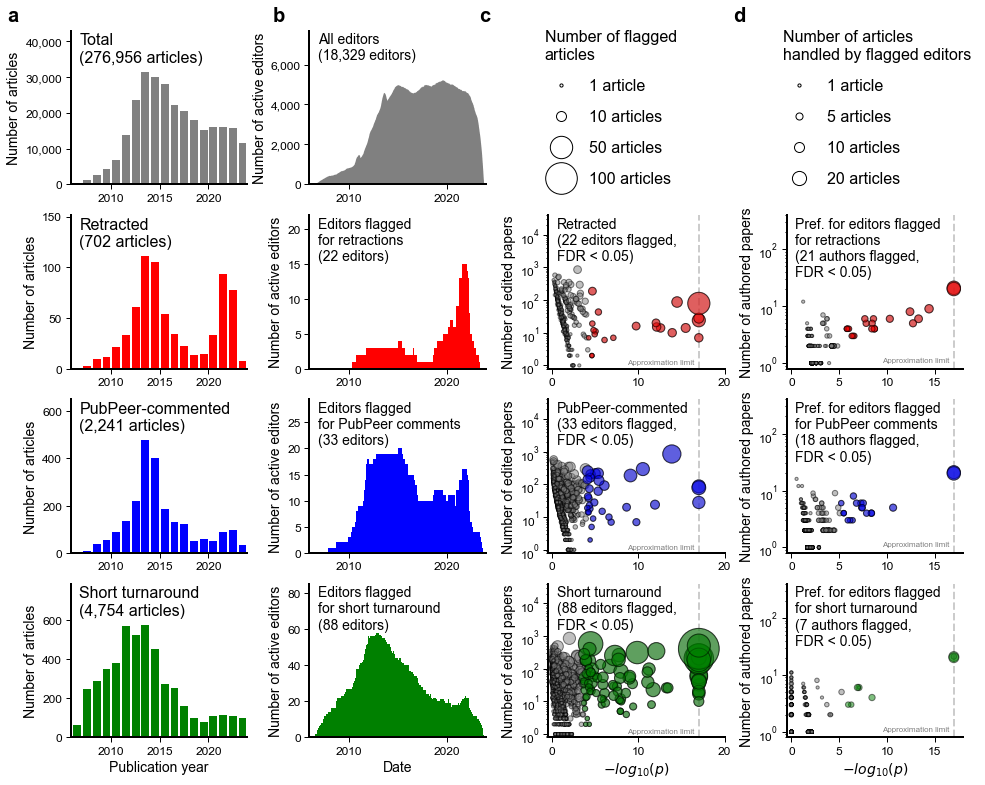

In [21]:
%%time

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(16,13), gridspec_kw={'hspace':0.2, 'wspace':0.35})

source_id = 'pone'

### first column: counts
year_series = editors_df.groupby('year').sum()
ax = axes[0][0]
ax.bar(x=year_series.index+0.5, height=year_series['total'], color='gray')
ax.set_title('Total\n(' + '{:,}'.format(editors_df['total'].sum()) + ' articles)', 
                 fontsize=16, ha='left', x=0.05, y=0.95, va='top')

ax = axes[1][0]
ax.bar(x=year_series.index+0.5, height=year_series['retracted'], color='red')
ax.set_title('Retracted\n(' + '{:,}'.format(editors_df['retracted'].sum()) + ' articles)', 
                 fontsize=16, ha='left', x=0.05, y=0.95, va='top')


ax = axes[2][0]
ax.bar(x=year_series.index+0.5, height=year_series['pubpeer'], color='blue')
ax.set_title('PubPeer-commented\n(' + '{:,}'.format(editors_df['pubpeer'].sum()) + ' articles)', 
                 fontsize=16, ha='left', x=0.05, y=0.95, va='top')

ax = axes[3][0]
ax.bar(x=year_series.index+0.5, height=year_series['short'], color='green')
ax.set_title('Short turnaround\n(' + '{:,}'.format(editors_df['short'].sum()) + ' articles)', 
                 fontsize=16, ha='left', x=0.05, y=0.95, va='top')

for ax in axes[:,0]:
    ax.set_ylim(bottom=0, top=ax.get_ylim()[1]*1.3)
    ax.set_xlim([2006-0.2,2024])
    ax.tick_params(width=1, length=5, which='major')
    ax.tick_params(width=1, length=2, which='minor')
    ax.tick_params(labelsize=12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    [ax.spines[i].set_linewidth(2) for i in ax.spines]
    ax.get_yaxis().set_major_formatter(
        mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    ax.set_ylabel('Number of articles', fontsize=14)
axes[3][0].set_xlabel('Publication year', fontsize=14)

    
### third column: editor enrichments
p_val_df = pd.read_csv('../data/240405_' + source_id + '_editor_p_values.csv')

# Retractions
ax = axes[1][2]
ax.scatter(-np.log10(p_val_df['retract_p_val']), p_val_df['total'],
               color='gray', linewidth=1, alpha=0.5, s=10*p_val_df['retracted'], edgecolor='k')
p_val_df_slice = p_val_df[p_val_df['retract_q_val'] < 0.05].copy()
ax.scatter(-np.log10(p_val_df_slice['retract_p_val']), p_val_df_slice['total'], 
               color='r', linewidth=1, alpha=0.5, s=10*p_val_df_slice['retracted'], edgecolor='k')
ax.set_title('Retracted\n(' + str(len(p_val_df_slice)) + ' editors flagged,\nFDR < 0.05)', 
                 fontsize=14, ha='left', x=0.05, y=0.95, va='top')

# PubPeer
ax = axes[2][2]
ax.scatter(-np.log10(p_val_df['pubpeer_p_val']), p_val_df['total'],
               color='gray', linewidth=1, alpha=0.5, s=10*p_val_df['pubpeer'], edgecolor='k')
p_val_df_slice = p_val_df[p_val_df['pubpeer_q_val'] < 0.05]
ax.scatter(-np.log10(p_val_df_slice['pubpeer_p_val']), p_val_df_slice['total'], 
               color='b', linewidth=1, alpha=0.5, s=10*p_val_df_slice['pubpeer'], edgecolor='k')
ax.set_title('PubPeer-commented\n(' + str(len(p_val_df_slice)) + ' editors flagged,\nFDR < 0.05)', 
                 fontsize=14, ha='left', x=0.05, y=0.95, va='top')
    
# Short
ax = axes[3][2]
ax.scatter(-np.log10(p_val_df['short_p_val']), p_val_df['total'],
               color='gray', linewidth=1, alpha=0.5, s=10*p_val_df['short'], edgecolor='k')
p_val_df_slice = p_val_df[p_val_df['short_q_val'] < 0.05]
ax.scatter(-np.log10(p_val_df_slice['short_p_val']), p_val_df_slice['total'],
               color='g', linewidth=1, alpha=0.5, s=10*p_val_df_slice['short'], edgecolor='k')
ax.set_title('Short turnaround\n(' + str(len(p_val_df_slice)) + ' editors flagged,\nFDR < 0.05)', 
                 fontsize=14, ha='left', x=0.05, y=0.95, va='top')
ax.set_xlabel(r'$-log_{10}(p)$', fontsize=14)

# legend
ax = axes[0][2]
ax.scatter([], [], s=10, color='w', alpha=1, linewidth=1, edgecolor='k', label='1 article')
ax.scatter([], [], s=100, color='w', alpha=1, linewidth=1, edgecolor='k', label='10 articles')
ax.scatter([], [], s=500, color='w', alpha=1, linewidth=1, edgecolor='k', label='50 articles')
ax.scatter([], [], s=1000, color='w', alpha=1, linewidth=1, edgecolor='k', label='100 articles')
#ax.scatter([], [], s=2000, color='w', alpha=1, linewidth=1, edgecolor='k', label='200 retracted/commented')
leg = ax.legend(fontsize=16, bbox_to_anchor=(-0.1,0.5), 
              loc='center left', frameon=False, labelspacing=1, handletextpad=0.75)
leg.set_title('Number of flagged\narticles')
plt.setp(leg.get_title(),fontsize=16, ha='left')
leg._legend_box.align = 'left'
ax.axis('off')

for ax in axes[1:,2]:
    ax.set_yscale('log')
    #ax.set_xlabel(r'$-log_{10}(p)$', fontsize=14)
    ax.set_ylabel('Number of edited papers', fontsize=14)
    ax.set_ylim([0.8, 40_000])
    ax.set_xlim([-0.5,20])
    ax.tick_params(width=1, length=5, which='major')
    ax.tick_params(width=1, length=2, which='minor')
    ax.tick_params(labelsize=12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    [ax.spines[i].set_linewidth(2) for i in ax.spines]
    ax.axvline(17, color='k', linewidth=2, linestyle='dashed', alpha=0.2, zorder=-10)
    ax.text(s='Approximation limit', x=16.5, y=1, fontsize=8, va='bottom', ha='right', color='k', alpha=0.5)
    
### second column: editor tenures

# all editors
ax = axes[0][1]
editors_of_interest = p_val_df['editor'].values
date_count_df = get_date_count_df(editors_df, date_df, editors_of_interest)
ax.fill_between(x=date_count_df['date'], 
                     y1=date_count_df['count'], 
                     y2=date_count_df['origin'], linewidth=0, color='gray')
ax.set_title('All editors\n' + '({:,} editors)'.format(len(editors_of_interest)),  
                 fontsize=14, ha='left', x=0.05, y=0.95, va='top')
if date_count_df['count'].max() < 4:
    ax.set_yticks(np.arange(0, date_count_df['count'].max()+1))

# retracted
ax = axes[1][1]
editors_of_interest = p_val_df[p_val_df['retract_q_val'] < 0.05]['editor'].values
date_count_df = get_date_count_df(editors_df, date_df, editors_of_interest)
ax.fill_between(x=date_count_df['date'], 
                     y1=date_count_df['count'], 
                     y2=date_count_df['origin'], linewidth=0, color='r')
ax.set_title('Editors flagged\nfor retractions\n' + '({:,} editors)'.format(len(editors_of_interest)), 
                 fontsize=14, ha='left', x=0.05, y=0.95, va='top')
if date_count_df['count'].max() < 4:
    ax.set_yticks(np.arange(0, date_count_df['count'].max()+1))
    
# pubpeer
ax = axes[2][1]
editors_of_interest = p_val_df[p_val_df['pubpeer_q_val'] < 0.05]['editor'].values
date_count_df = get_date_count_df(editors_df, date_df, editors_of_interest)
ax.fill_between(x=date_count_df['date'], 
                     y1=date_count_df['count'], 
                     y2=date_count_df['origin'], linewidth=0, color='b')
ax.set_title('Editors flagged\nfor PubPeer comments\n' + '({:,} editors)'.format(len(editors_of_interest)), 
                 fontsize=14, ha='left', x=0.05, y=0.95, va='top')
if date_count_df['count'].max() < 4:
    ax.set_yticks(np.arange(0, date_count_df['count'].max()+1))
    
# turnaround
ax = axes[3][1]
editors_of_interest = p_val_df[p_val_df['short_q_val'] < 0.05]['editor'].values
date_count_df = get_date_count_df(editors_df, date_df, editors_of_interest)
ax.fill_between(x=date_count_df['date'], 
                     y1=date_count_df['count'], 
                     y2=date_count_df['origin'], linewidth=0, color='g')
ax.set_title('Editors flagged\nfor short turnaround\n' + '({:,} editors)'.format(len(editors_of_interest)), 
                 fontsize=14, ha='left', x=0.05, y=0.95, va='top')
if date_count_df['count'].max() < 4:
    ax.set_yticks(np.arange(0, date_count_df['count'].max()+1))
axes[3][1].set_xlabel('Date', fontsize=14)


for ax in axes[:,1]:
    ax.set_ylim(bottom=0)
    ax.set_xlim([pd.to_datetime('Jan 1, 2006'), pd.to_datetime('Jan 1, 2024')])
    ax.set_xticks([pd.to_datetime('Jan 1, 2010'), pd.to_datetime('Jan 1, 2020')])
    ax.tick_params(width=1, length=5, which='major')
    ax.tick_params(width=1, length=2, which='minor')
    ax.tick_params(labelsize=12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylabel('Number of active editors', fontsize=14)
    [ax.spines[i].set_linewidth(2) for i in ax.spines]
    ax.set_ylim(bottom=0, top=ax.get_ylim()[1]*1.4)
    if ax.get_ylim()[1] < 20:
        ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    ax.get_yaxis().set_major_formatter(
        mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    myFmt = mpl.dates.DateFormatter('%Y')
    ax.xaxis.set_major_formatter(myFmt)
    
### fourth column: authors enrichment for editors

# This variable would have contained a list of flagged author ORCiDs that also
# turned out to be editors at PLOS One, compiled through manual inspection. It
# has been removed here.
# editor_orcids = []

p_val_df = pd.read_csv('../data/240405_' + source_id + '_author_orcid_p_values_fdr.csv')

# Retractions
ax = axes[1][3]
ax.scatter(-np.log10(p_val_df['retract_suspect_p_val']), p_val_df['total'],
               color='gray', linewidth=1, alpha=0.5, s=10*p_val_df['retract_suspect'], edgecolor='k')
p_val_df_slice = p_val_df[p_val_df['retract_suspect_q_val'] < 0.05].copy()
ax.scatter(-np.log10(p_val_df_slice['retract_suspect_p_val']), p_val_df_slice['total'], 
               color='r', linewidth=1, alpha=0.5, s=10*p_val_df_slice['retract_suspect'], edgecolor='k')
ax.set_title('Pref. for editors flagged\nfor retractions\n(' + str(len(p_val_df_slice)) + ' authors flagged,\nFDR < 0.05)', 
                 fontsize=14, ha='left', x=0.05, y=0.95, va='top')
#p_val_df_slice = p_val_df_slice[p_val_df_slice['author'].isin(editor_orcids)].copy()

# PubPeer
ax = axes[2][3]
ax.scatter(-np.log10(p_val_df['pubpeer_suspect_p_val']), p_val_df['total'],
               color='gray', linewidth=1, alpha=0.5, s=10*p_val_df['pubpeer_suspect'], edgecolor='k')
p_val_df_slice = p_val_df[p_val_df['pubpeer_suspect_q_val'] < 0.05]
ax.scatter(-np.log10(p_val_df_slice['pubpeer_suspect_p_val']), p_val_df_slice['total'], 
               color='b', linewidth=1, alpha=0.5, s=10*p_val_df_slice['pubpeer_suspect'], edgecolor='k')
ax.set_title('Pref. for editors flagged\nfor PubPeer comments\n(' + str(len(p_val_df_slice)) + ' authors flagged,\nFDR < 0.05)', 
                 fontsize=14, ha='left', x=0.05, y=0.95, va='top')
#p_val_df_slice = p_val_df_slice[p_val_df_slice['author'].isin(editor_orcids)].copy()
    
# Short
ax = axes[3][3]
ax.scatter(-np.log10(p_val_df['short_suspect_p_val']), p_val_df['total'],
               color='gray', linewidth=1, alpha=0.5, s=10*p_val_df['short'], edgecolor='k')
p_val_df_slice = p_val_df[p_val_df['short_suspect_q_val'] < 0.05]
ax.scatter(-np.log10(p_val_df_slice['short_suspect_p_val']), p_val_df_slice['total'],
               color='g', linewidth=1, alpha=0.5, s=10*p_val_df_slice['short_suspect'], edgecolor='k')
ax.set_title('Pref. for editors flagged\nfor short turnaround\n(' + str(len(p_val_df_slice)) + ' authors flagged,\nFDR < 0.05)', 
                 fontsize=14, ha='left', x=0.05, y=0.95, va='top')
#p_val_df_slice = p_val_df_slice[p_val_df_slice['author'].isin(editor_orcids)].copy()

ax.set_xlabel(r'$-log_{10}(p)$', fontsize=14)

# legend
ax = axes[0][3]
ax.scatter([], [], s=10, color='w', alpha=1, linewidth=1, edgecolor='k', label='1 article')
ax.scatter([], [], s=50, color='w', alpha=1, linewidth=1, edgecolor='k', label='5 articles')
ax.scatter([], [], s=100, color='w', alpha=1, linewidth=1, edgecolor='k', label='10 articles')
ax.scatter([], [], s=200, color='w', alpha=1, linewidth=1, edgecolor='k', label='20 articles')
#ax.scatter([], [], s=2000, color='w', alpha=1, linewidth=1, edgecolor='k', label='200 retracted/commented')
leg = ax.legend(fontsize=16, bbox_to_anchor=(-0.1,0.5), 
              loc='center left', frameon=False, labelspacing=1, handletextpad=0.75)
leg.set_title('Number of articles\nhandled by flagged editors')
plt.setp(leg.get_title(),fontsize=16, ha='left')
leg._legend_box.align = 'left'
ax.axis('off')

for ax in axes[1:,3]:
    ax.set_yscale('log')
    #ax.set_xlabel(r'$-log_{10}(p)$', fontsize=14)
    ax.set_ylabel('Number of authored papers', fontsize=14)
    ax.set_ylim([0.8, 4_00])
    ax.set_xlim([-0.5,18])
    ax.tick_params(width=1, length=5, which='major')
    ax.tick_params(width=1, length=2, which='minor')
    ax.tick_params(labelsize=12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    [ax.spines[i].set_linewidth(2) for i in ax.spines]
    ax.axvline(17, color='k', linewidth=2, linestyle='dashed', alpha=0.2, zorder=-10)
    ax.text(s='Approximation limit', x=16.5, y=1, fontsize=8, va='bottom', ha='right', color='k', alpha=0.5)
    
fig.text(s='a', x=0.07, y=0.89, fontsize=20, weight='bold')
fig.text(s='b', x=0.3, y=0.89, fontsize=20, weight='bold')
fig.text(s='c', x=0.48, y=0.89, fontsize=20, weight='bold')
fig.text(s='d', x=0.70, y=0.89, fontsize=20, weight='bold')      
fig.savefig('../img/240411_' + source_id + '_summary_fig_fdr.png', dpi=200, bbox_inches='tight')

# Figure S3

Restrict to just a specific field with the most retractions (landed on molecular cell biology since this has a lot of retractions but is specific enough a field that any editor in the field could plausibly serve as editor for any article)

In [22]:
subj_df = subj_df[subj_df['doi'].isin(accept_dois)].copy()
subj_df = subj_df[~subj_df['subject'].isin(type_df['content_type'])]

In [23]:
subj_df = subj_df.drop_duplicates()

In [24]:
subj_df[subj_df['doi'].isin(a)]['subject'].value_counts().head(50)

Biology and life sciences             374
Medicine and health sciences          255
Biochemistry                          222
Biology                               184
Research and analysis methods         179
Oncology                              174
Physical sciences                     170
Organisms                             170
Cell biology                          163
Medicine                              157
Molecular cell biology                155
Eukaryota                             145
Genetics                              143
Cancers and neoplasms                 135
Plant science                         122
Plants                                121
Physiology                            105
Cellular types                        104
Chemistry                             104
Gene expression                       103
Agriculture                           101
Signal transduction                    98
Plant anatomy                          91
Proteins                          

In [25]:
subj_df[subj_df['subject'] == 'Molecular cell biology']['doi'].values

array(['10.1371/journal.pone.0015001', '10.1371/journal.pone.0015008',
       '10.1371/journal.pone.0015012', ...,
       '10.1371/journal.pone.0116282', '10.1371/journal.pone.0116455',
       '10.1371/journal.pone.0116567'], dtype=object)

No aff_df at 344000
No aff_df at 345710


C:\Users\richa\AppData\Local\Temp\ipykernel_29028\807413688.py:71: DtypeWarning: Columns (1,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  pubpeer_df = pd.read_csv('C:/Users/richa/OneDrive - Northwestern University/pubpeer_comments_20240201.csv')
C:\Users\richa\AppData\Local\Temp\ipykernel_29028\807413688.py:88: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  editors_df['full_name'] = editors_df['full_name'].str.replace('.', '').str.replace(' ', '').str.lower()


  0%|          | 0/7302 [00:00<?, ?it/s]

  0%|          | 0/7302 [00:00<?, ?it/s]

  0%|          | 0/7302 [00:00<?, ?it/s]

  0%|          | 0/7302 [00:00<?, ?it/s]

  0%|          | 0/7302 [00:00<?, ?it/s]

92.22% of authors have no ORCID
60.52% of articles have no author ORCID


  0%|          | 0/25138 [00:00<?, ?it/s]

  0%|          | 0/25138 [00:00<?, ?it/s]

  0%|          | 0/25138 [00:00<?, ?it/s]

  0%|          | 0/25138 [00:00<?, ?it/s]

  0%|          | 0/25138 [00:00<?, ?it/s]

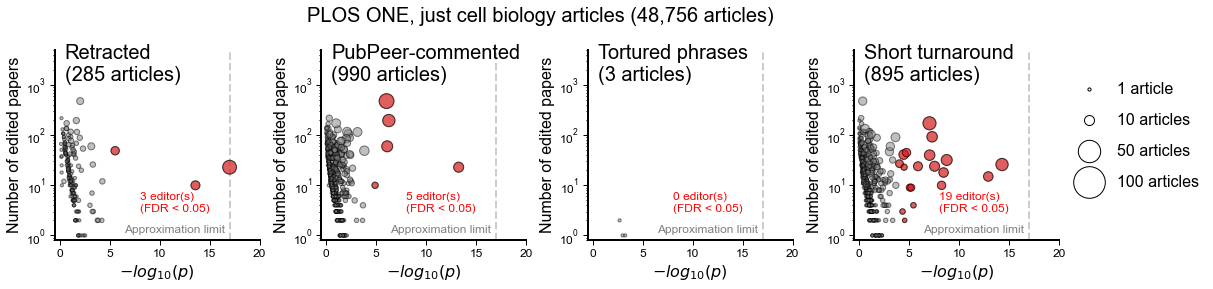

In [26]:
aff_df = []
type_df = []
date_df = []
contrib_df = []
subj_df = []

for n in list(range(1_000, 346_000, 1_000)) + [345_710]:
    contrib_df.append(pd.read_csv('../data/231109_plos_contributors_' + str(n) + '.csv'))
    type_df.append(pd.read_csv('../data/231109_plos_content_type_' + str(n) + '.csv'))
    date_df.append(pd.read_csv('../data/231109_plos_handling_time_' + str(n) + '.csv'))
    try:
        aff_df.append(pd.read_csv('../data/231109_plos_aff_' + str(n) + '.csv'))
    except:
        print('No aff_df at ' + str(n))
    subj_df.append(pd.read_csv('../data/231109_plos_subj_' + str(n) + '.csv'))

subj_df = pd.concat(subj_df).reset_index(drop=True)
contrib_df = pd.concat(contrib_df).reset_index(drop=True)
type_df = pd.concat(type_df).reset_index(drop=True)
date_df = pd.concat(date_df).reset_index(drop=True)
aff_df = pd.concat(aff_df).reset_index(drop=True)

type_df = type_df.drop_duplicates()

acceptable_types = ['Research Article', 'Review', 'Study Protocol', 
                    'Registered Report Protocol', 'Clinical Trial', 
                    'Lab Protocol', 'Collection Review']

type_df = type_df[type_df['content_type'].isin(acceptable_types)]
type_df['journal'] = type_df['doi'].apply(lambda x: x.split('.')[:-1][-1])
type_df = type_df[type_df['journal'] == 'pone']
accept_dois = type_df['doi'].values

### Restrict to just Cell biology

subj_df = subj_df[subj_df['doi'].isin(accept_dois)].copy()
subj_df = subj_df[~subj_df['subject'].isin(type_df['content_type'])]
accept_dois = subj_df[subj_df['subject'].isin(['Cell biology', 'Molecular cell biology'])]['doi'].values

###

contrib_df = contrib_df[contrib_df['doi'].isin(accept_dois)]
contrib_df = contrib_df.sort_values('orcid').drop_duplicates(subset=['doi', 'contrib', 'contrib_type', 'orcid'])
authors_df = contrib_df[contrib_df['contrib_type'] == 'author'].copy()
editors_df = contrib_df[contrib_df['contrib_type'].isin(['editor'])].copy()

editors_df = editors_df.drop_duplicates('doi', keep='first')[['doi', 'contrib', 'contrib_type']].rename(columns={'contrib':'full_name'})

authors_df['orcid'] = authors_df['orcid'].astype(str).apply(lambda x: x.split('/')[-1].strip())

date_df['date'] = pd.to_datetime(date_df['day'].astype(str) + '-' + date_df['month'].astype(str) + '-' + date_df['year'].astype(str), 
               dayfirst=True, errors='coerce')
date_df = date_df.sort_values('date').drop_duplicates(['doi', 'date_type'])\
.pivot(index='doi', columns='date_type', values='date').reset_index()
date_df['days'] = [x.days for x in (date_df['accepted'] - date_df['received'])]
date_df['year'] = [x.year for x in date_df['Published']]
short_time_dois = date_df[date_df['days'] <= 30]['doi'].values

master_authors_df = authors_df.copy()
master_authors_df['orcid'] = master_authors_df['orcid'].replace('nan', np.nan)
editors_df = pd.merge(editors_df, date_df[['doi', 'year']])
master_authors_df = pd.merge(master_authors_df, date_df[['doi', 'year']])

# Retractions
rw_db = pd.read_csv('../data/240304_retraction_watch_db.csv', encoding='latin')
a = rw_db[rw_db['RetractionNature'] == 'Retraction']['OriginalPaperDOI'].values
a = [str(x).lower() for x in a]
#a = rw_db['OriginalPaperDOI'].values

# Pubpeer
pubpeer_df = pd.read_csv('C:/Users/richa/OneDrive - Northwestern University/pubpeer_comments_20240201.csv')
pubpeer_df['id'] = pubpeer_df['ids'].astype(str).apply(lambda x: x.split(','))
pubpeer_df = pubpeer_df.explode('id')
pubpeer_df['paper_link'] = pubpeer_df['Pubpeer Link'].astype(str).apply(lambda x: '/'.join(x.split('/')[:-1])).values
b = pubpeer_df['id'].values

# Tortured Phrases
tort_df = pd.read_csv('../data/240321_tortured_phrases.csv')

editors_df['retracted'] = editors_df['doi'].isin(a)
editors_df['pubpeer'] = editors_df['doi'].isin(b)
editors_df['either'] = editors_df['retracted'] | editors_df['pubpeer']
editors_df['tortured'] = editors_df['doi'].isin(tort_df['DOI'].str.lower().values)
editors_df['short'] = editors_df['doi'].isin(short_time_dois)
editors_df['total'] = True


editors_df['full_name'] = editors_df['full_name'].str.replace('.', '').str.replace(' ', '').str.lower()

master_editors_df = editors_df.copy()

for source_id in ['pone']:
    editors_df = master_editors_df[master_editors_df['doi'].isin(accept_dois)]


    # In[17]:


    rate_df = editors_df.groupby('year').sum()[['retracted', 'pubpeer', 'either', 'tortured', 'short', 'total']]

    rate_df['p_retracted'] = rate_df['retracted']/rate_df['total']
    rate_df['p_pubpeer'] = rate_df['pubpeer']/rate_df['total']
    rate_df['p_tortured'] = rate_df['tortured']/rate_df['total']
    rate_df['p_either'] = rate_df['either']/rate_df['total']
    rate_df['p_short'] = rate_df['short']/rate_df['total']


    # In[18]:


    summary_by_editor = editors_df.groupby('full_name').sum()


    # In[19]:


    editor_year_list = editors_df.groupby('full_name')['year'].apply(list)

    rate_dict = rate_df['p_retracted'].to_dict()
    p_val_array = []
    editor_list = []
    for editor, row in tqdm(pd.DataFrame(editor_year_list).iterrows(), total=len(editor_year_list)):
        year_list = row['year']
        p_array = [rate_dict.get(x) for x in year_list]
        p_val = PoiBin(p_array).pval(int(summary_by_editor.loc[editor]['retracted']))
        editor_list.append(editor)
        p_val_array.append(p_val)

    p_val_df = pd.DataFrame({'editor':editor_list, 'retract_p_val':p_val_array})

    rate_dict = rate_df['p_pubpeer'].to_dict()
    p_val_array = []
    editor_list = []
    for editor, row in tqdm(pd.DataFrame(editor_year_list).iterrows(), total=len(editor_year_list)):
        year_list = row['year']
        p_array = [rate_dict.get(x) for x in year_list]
        p_val = PoiBin(p_array).pval(int(summary_by_editor.loc[editor]['pubpeer']))
        editor_list.append(editor)
        p_val_array.append(p_val)

    p_val_df['pubpeer_p_val'] = p_val_array

    rate_dict = rate_df['p_either'].to_dict()
    p_val_array = []
    editor_list = []
    for editor, row in tqdm(pd.DataFrame(editor_year_list).iterrows(), total=len(editor_year_list)):
        year_list = row['year']
        p_array = [rate_dict.get(x) for x in year_list]
        p_val = PoiBin(p_array).pval(int(summary_by_editor.loc[editor]['either']))
        editor_list.append(editor)
        p_val_array.append(p_val)

    p_val_df['either_p_val'] = p_val_array
    
    rate_dict = rate_df['p_tortured'].to_dict()
    p_val_array = []
    editor_list = []
    for editor, row in tqdm(pd.DataFrame(editor_year_list).iterrows(), total=len(editor_year_list)):
        year_list = row['year']
        p_array = [rate_dict.get(x) for x in year_list]
        p_val = PoiBin(p_array).pval(int(summary_by_editor.loc[editor]['tortured']))
        editor_list.append(editor)
        p_val_array.append(p_val)

    p_val_df['tortured_p_val'] = p_val_array

    rate_dict = rate_df['p_short'].to_dict()
    p_val_array = []
    editor_list = []
    for editor, row in tqdm(pd.DataFrame(editor_year_list).iterrows(), total=len(editor_year_list)):
        year_list = row['year']
        p_array = [rate_dict.get(x) for x in year_list]
        p_val = PoiBin(p_array).pval(int(summary_by_editor.loc[editor]['short']))
        editor_list.append(editor)
        p_val_array.append(p_val)

    p_val_df['short_p_val'] = p_val_array

    for col in ['retract_p_val', 'pubpeer_p_val', 'either_p_val', 'tortured_p_val', 'short_p_val']:
        p_val_df.loc[p_val_df[col] < 0, col] = 1e-17
        p_val_df[col.split('_')[0]+'_q_val'] = multipletests(p_val_df[col], method='fdr_bh')[1]
        p_val_df[col.split('_')[0]+'_fwer'] = multipletests(p_val_df[col], method='bonferroni')[1]

    p_val_df = pd.merge(p_val_df, summary_by_editor.reset_index().rename(columns={'full_name':'editor'}))

    fig, axes = plt.subplots(ncols=4, nrows=1, figsize=(18,3.5), gridspec_kw={'wspace':0.3})

    # Retractions
    ax = axes[0]
    ax.scatter(-np.log10(p_val_df['retract_p_val']), p_val_df['total'],
               color='gray', linewidth=1, alpha=0.5, s=10*p_val_df['retracted'], edgecolor='k')
    p_val_df_slice = p_val_df[p_val_df['retract_q_val'] < 0.05].copy()
    ax.scatter(-np.log10(p_val_df_slice['retract_p_val']), p_val_df_slice['total'], 
               color='r', linewidth=1, alpha=0.5, s=10*p_val_df_slice['retracted'], edgecolor='k')
    ax.set_title('Retracted\n(' + '{:,}'.format(editors_df['retracted'].sum()) + ' articles)', 
                 fontsize=20, ha='left', x=0.05, y=1.0, va='top')
    ax.text(s=str(len(p_val_df_slice)) + ' editor(s)\n(FDR < 0.05)', fontsize=12, y=3, x=8, color='r')

    # PubPeer
    ax = axes[1]
    ax.scatter(-np.log10(p_val_df['pubpeer_p_val']), p_val_df['total'],
               color='gray', linewidth=1, alpha=0.5, s=10*p_val_df['pubpeer'], edgecolor='k')
    p_val_df_slice = p_val_df[p_val_df['pubpeer_q_val'] < 0.05]
    ax.scatter(-np.log10(p_val_df_slice['pubpeer_p_val']), p_val_df_slice['total'], 
               color='r', linewidth=1, alpha=0.5, s=10*p_val_df_slice['pubpeer'], edgecolor='k')
    ax.set_title('PubPeer-commented\n(' + '{:,}'.format(editors_df['pubpeer'].sum()) + ' articles)', 
                 fontsize=20, ha='left', x=0.05, y=1.0, va='top')
    ax.text(s=str(len(p_val_df_slice)) + ' editor(s)\n(FDR < 0.05)', fontsize=12, y=3, x=8, color='r')

    # Tortured
    ax = axes[2]
    ax.scatter(-np.log10(p_val_df['tortured_p_val']), p_val_df['total'],
               color='gray', linewidth=1, alpha=0.5, s=10*p_val_df['tortured'], edgecolor='k')
    p_val_df_slice = p_val_df[p_val_df['tortured_q_val'] < 0.05]
    ax.scatter(-np.log10(p_val_df_slice['tortured_p_val']), p_val_df_slice['total'],
               color='r', linewidth=1, alpha=0.5, s=10*p_val_df_slice['tortured'], edgecolor='k')
    ax.set_title('Tortured phrases\n(' + '{:,}'.format(editors_df['tortured'].sum()) + ' articles)', 
                 fontsize=20, ha='left', x=0.05, y=1.0, va='top')
    ax.text(s=str(len(p_val_df_slice)) + ' editor(s)\n(FDR < 0.05)', fontsize=12, y=3, x=8, color='r')
    
    # Short
    ax = axes[3]
    ax.scatter(-np.log10(p_val_df['short_p_val']), p_val_df['total'],
               color='gray', linewidth=1, alpha=0.5, s=10*p_val_df['short'], edgecolor='k')
    p_val_df_slice = p_val_df[p_val_df['short_q_val'] < 0.05]
    ax.scatter(-np.log10(p_val_df_slice['short_p_val']), p_val_df_slice['total'],
               color='r', linewidth=1, alpha=0.5, s=10*p_val_df_slice['short'], edgecolor='k')
    ax.set_title('Short turnaround\n(' + '{:,}'.format(editors_df['short'].sum()) + ' articles)', 
                 fontsize=20, ha='left', x=0.05, y=1.0, va='top')
    ax.text(s=str(len(p_val_df_slice)) + ' editor(s)\n(FDR < 0.05)', fontsize=12, y=3, x=8, color='r')

    ax.scatter([], [], s=10, color='w', alpha=1, linewidth=1, edgecolor='k', label='1 article')
    ax.scatter([], [], s=100, color='w', alpha=1, linewidth=1, edgecolor='k', label='10 articles')
    ax.scatter([], [], s=500, color='w', alpha=1, linewidth=1, edgecolor='k', label='50 articles')
    ax.scatter([], [], s=1000, color='w', alpha=1, linewidth=1, edgecolor='k', label='100 articles')
    #ax.scatter([], [], s=2000, color='w', alpha=1, linewidth=1, edgecolor='k', label='200 retracted/commented')
    ax.legend(fontsize=16, bbox_to_anchor=(1,0.55), loc='center left', frameon=False, labelspacing=1, handletextpad=0.75)

    for ax in axes:
        ax.set_yscale('log')
        ax.set_xlabel(r'$-log_{10}(p)$', fontsize=16)
        ax.set_ylabel('Number of edited papers', fontsize=16)
        ax.set_ylim([0.8, 5000])
        ax.set_xlim([-0.5,20])
        ax.tick_params(width=1, length=5, which='major')
        ax.tick_params(width=1, length=2, which='minor')
        ax.tick_params(labelsize=12)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        [ax.spines[i].set_linewidth(2) for i in ax.spines]
        ax.axvline(17, color='k', linewidth=2, linestyle='dashed', alpha=0.2, zorder=-10)
        ax.text(s='Approximation limit', x=16.5, y=1, fontsize=12, va='bottom', ha='right', color='k', alpha=0.5)
    
    title = "PLOS ONE, just cell biology articles"
        
    fig.suptitle(title + ' (' + '{:,}'.format(len(editors_df)) + ' articles)', y=1.05, fontsize=20)
    fig.savefig('../img/240405_' + source_id + '_p_value_axis_flip_cell_biology.png', dpi=200, bbox_inches='tight')
    p_val_df.to_csv('../data/240405_' + source_id + '_editor_p_values_cell_biology.csv', index=False)
    
    # author attributes
    authors_df = master_authors_df[master_authors_df['doi'].isin(editors_df['doi'])]
    
    print('{:.2f}'.format(100*authors_df['orcid'].isna().mean()) + '% of authors have no ORCID')
    print('{:.2f}'.format(100-(100*authors_df[~authors_df['orcid'].isna()]['doi'].nunique()/authors_df['doi'].nunique())) + '% of articles have no author ORCID')
    
    
    
    #### authors with preferences towards suspect editors
    for col in ['retract', 'pubpeer', 'either', 'tortured', 'short']:
        editors_df[col + '_suspect'] = editors_df['full_name'].isin(p_val_df[p_val_df[col + '_q_val'] < 0.05]['editor'])

    rate_df = editors_df.groupby('year').sum()[['retract_suspect', 'pubpeer_suspect', 'either_suspect', 'tortured_suspect', 'short_suspect', 'total']]

    rate_df['p_retract_suspect'] = rate_df['retract_suspect']/rate_df['total']
    rate_df['p_pubpeer_suspect'] = rate_df['pubpeer_suspect']/rate_df['total']
    rate_df['p_either_suspect'] = rate_df['either_suspect']/rate_df['total']
    rate_df['p_tortured_suspect'] = rate_df['tortured_suspect']/rate_df['total']
    rate_df['p_short_suspect'] = rate_df['short_suspect']/rate_df['total']

    ###### By ORCID ID
    summary_by_author = pd.merge(master_authors_df, editors_df, on='doi').dropna(subset=['orcid']).groupby('orcid').sum()

    author_year_list = authors_df.dropna(subset=['orcid']).groupby('orcid')['year'].apply(list)

    rate_dict = rate_df['p_retract_suspect'].to_dict()
    p_val_array = []
    author_list = []
    for author, row in tqdm(pd.DataFrame(author_year_list).iterrows(), total=len(author_year_list)):
        year_list = row['year']
        p_array = [rate_dict.get(x) for x in year_list]
        p_val = PoiBin(p_array).pval(int(summary_by_author.loc[author]['retract_suspect']))
        author_list.append(author)
        p_val_array.append(p_val)

    author_p_val_df = pd.DataFrame({'author':author_list, 'retract_suspect_p_val':p_val_array})

    rate_dict = rate_df['p_pubpeer_suspect'].to_dict()
    p_val_array = []
    author_list = []
    for author, row in tqdm(pd.DataFrame(author_year_list).iterrows(), total=len(author_year_list)):
        year_list = row['year']
        p_array = [rate_dict.get(x) for x in year_list]
        p_val = PoiBin(p_array).pval(int(summary_by_author.loc[author]['pubpeer_suspect']))
        author_list.append(author)
        p_val_array.append(p_val)

    author_p_val_df['pubpeer_suspect_p_val'] = p_val_array

    rate_dict = rate_df['p_tortured_suspect'].to_dict()
    p_val_array = []
    author_list = []
    for author, row in tqdm(pd.DataFrame(author_year_list).iterrows(), total=len(author_year_list)):
        year_list = row['year']
        p_array = [rate_dict.get(x) for x in year_list]
        p_val = PoiBin(p_array).pval(int(summary_by_author.loc[author]['tortured_suspect']))
        author_list.append(author)
        p_val_array.append(p_val)

    author_p_val_df['tortured_suspect_p_val'] = p_val_array

    rate_dict = rate_df['p_short_suspect'].to_dict()
    p_val_array = []
    author_list = []
    for author, row in tqdm(pd.DataFrame(author_year_list).iterrows(), total=len(author_year_list)):
        year_list = row['year']
        p_array = [rate_dict.get(x) for x in year_list]
        p_val = PoiBin(p_array).pval(int(summary_by_author.loc[author]['short_suspect']))
        author_list.append(author)
        p_val_array.append(p_val)

    author_p_val_df['short_suspect_p_val'] = p_val_array

    rate_dict = rate_df['p_either_suspect'].to_dict()
    p_val_array = []
    editor_list = []
    for author, row in tqdm(pd.DataFrame(author_year_list).iterrows(), total=len(author_year_list)):
        year_list = row['year']
        p_array = [rate_dict.get(x) for x in year_list]
        p_val = PoiBin(p_array).pval(int(summary_by_author.loc[author]['either_suspect']))
        editor_list.append(editor)
        p_val_array.append(p_val)

    author_p_val_df['either_suspect_p_val'] = p_val_array

    for col in ['retract_suspect_p_val', 'pubpeer_suspect_p_val', 'either_suspect_p_val', 'tortured_suspect_p_val', 'short_suspect_p_val']:
        author_p_val_df.loc[author_p_val_df[col] < 0, col] = 1e-17
        author_p_val_df[col.split('_')[0]+'_' + col.split('_')[1] + '_q_val'] = multipletests(author_p_val_df[col], method='fdr_bh')[1]
        author_p_val_df[col.split('_')[0]+'_' + col.split('_')[1] + '_fwer'] = multipletests(author_p_val_df[col], method='bonferroni')[1]

    author_p_val_df = pd.merge(author_p_val_df, summary_by_author.reset_index().rename(columns={'orcid':'author'}))
    author_p_val_df.to_csv('../data/240405_' + source_id + '_author_orcid_p_values_cell_biology.csv', index=False)

CPU times: total: 9.17 s
Wall time: 9.16 s


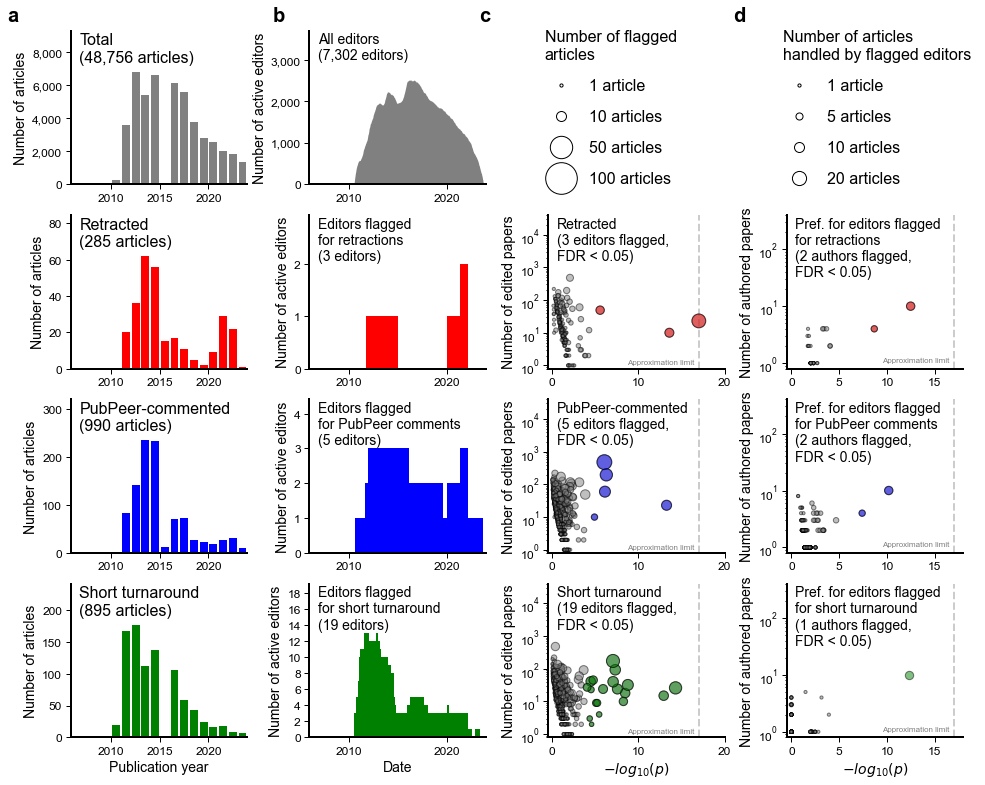

In [27]:
%%time

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(16,13), gridspec_kw={'hspace':0.2, 'wspace':0.35})

source_id = 'pone'

### first column: counts
year_series = editors_df.groupby('year').sum()
ax = axes[0][0]
ax.bar(x=year_series.index+0.5, height=year_series['total'], color='gray')
ax.set_title('Total\n(' + '{:,}'.format(editors_df['total'].sum()) + ' articles)', 
                 fontsize=16, ha='left', x=0.05, y=0.95, va='top')

ax = axes[1][0]
ax.bar(x=year_series.index+0.5, height=year_series['retracted'], color='red')
ax.set_title('Retracted\n(' + '{:,}'.format(editors_df['retracted'].sum()) + ' articles)', 
                 fontsize=16, ha='left', x=0.05, y=0.95, va='top')


ax = axes[2][0]
ax.bar(x=year_series.index+0.5, height=year_series['pubpeer'], color='blue')
ax.set_title('PubPeer-commented\n(' + '{:,}'.format(editors_df['pubpeer'].sum()) + ' articles)', 
                 fontsize=16, ha='left', x=0.05, y=0.95, va='top')

ax = axes[3][0]
ax.bar(x=year_series.index+0.5, height=year_series['short'], color='green')
ax.set_title('Short turnaround\n(' + '{:,}'.format(editors_df['short'].sum()) + ' articles)', 
                 fontsize=16, ha='left', x=0.05, y=0.95, va='top')

for ax in axes[:,0]:
    ax.set_ylim(bottom=0, top=ax.get_ylim()[1]*1.3)
    ax.set_xlim([2006-0.2,2024])
    ax.tick_params(width=1, length=5, which='major')
    ax.tick_params(width=1, length=2, which='minor')
    ax.tick_params(labelsize=12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    [ax.spines[i].set_linewidth(2) for i in ax.spines]
    ax.get_yaxis().set_major_formatter(
        mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    ax.set_ylabel('Number of articles', fontsize=14)
axes[3][0].set_xlabel('Publication year', fontsize=14)

    
### second column: editor enrichments
p_val_df = pd.read_csv('../data/240405_' + source_id + '_editor_p_values_cell_biology.csv')

# Retractions
ax = axes[1][2]
ax.scatter(-np.log10(p_val_df['retract_p_val']), p_val_df['total'],
               color='gray', linewidth=1, alpha=0.5, s=10*p_val_df['retracted'], edgecolor='k')
p_val_df_slice = p_val_df[p_val_df['retract_q_val'] < 0.05].copy()
ax.scatter(-np.log10(p_val_df_slice['retract_p_val']), p_val_df_slice['total'], 
               color='r', linewidth=1, alpha=0.5, s=10*p_val_df_slice['retracted'], edgecolor='k')
ax.set_title('Retracted\n(' + str(len(p_val_df_slice)) + ' editors flagged,\nFDR < 0.05)', 
                 fontsize=14, ha='left', x=0.05, y=0.95, va='top')

# PubPeer
ax = axes[2][2]
ax.scatter(-np.log10(p_val_df['pubpeer_p_val']), p_val_df['total'],
               color='gray', linewidth=1, alpha=0.5, s=10*p_val_df['pubpeer'], edgecolor='k')
p_val_df_slice = p_val_df[p_val_df['pubpeer_q_val'] < 0.05]
ax.scatter(-np.log10(p_val_df_slice['pubpeer_p_val']), p_val_df_slice['total'], 
               color='b', linewidth=1, alpha=0.5, s=10*p_val_df_slice['pubpeer'], edgecolor='k')
ax.set_title('PubPeer-commented\n(' + str(len(p_val_df_slice)) + ' editors flagged,\nFDR < 0.05)', 
                 fontsize=14, ha='left', x=0.05, y=0.95, va='top')
    
# Short
ax = axes[3][2]
ax.scatter(-np.log10(p_val_df['short_p_val']), p_val_df['total'],
               color='gray', linewidth=1, alpha=0.5, s=10*p_val_df['short'], edgecolor='k')
p_val_df_slice = p_val_df[p_val_df['short_q_val'] < 0.05]
ax.scatter(-np.log10(p_val_df_slice['short_p_val']), p_val_df_slice['total'],
               color='g', linewidth=1, alpha=0.5, s=10*p_val_df_slice['short'], edgecolor='k')
ax.set_title('Short turnaround\n(' + str(len(p_val_df_slice)) + ' editors flagged,\nFDR < 0.05)', 
                 fontsize=14, ha='left', x=0.05, y=0.95, va='top')
ax.set_xlabel(r'$-log_{10}(p)$', fontsize=14)

# legend
ax = axes[0][2]
ax.scatter([], [], s=10, color='w', alpha=1, linewidth=1, edgecolor='k', label='1 article')
ax.scatter([], [], s=100, color='w', alpha=1, linewidth=1, edgecolor='k', label='10 articles')
ax.scatter([], [], s=500, color='w', alpha=1, linewidth=1, edgecolor='k', label='50 articles')
ax.scatter([], [], s=1000, color='w', alpha=1, linewidth=1, edgecolor='k', label='100 articles')
#ax.scatter([], [], s=2000, color='w', alpha=1, linewidth=1, edgecolor='k', label='200 retracted/commented')
leg = ax.legend(fontsize=16, bbox_to_anchor=(-0.1,0.5), 
              loc='center left', frameon=False, labelspacing=1, handletextpad=0.75)
leg.set_title('Number of flagged\narticles')
plt.setp(leg.get_title(),fontsize=16, ha='left')
leg._legend_box.align = 'left'
ax.axis('off')

for ax in axes[1:,2]:
    ax.set_yscale('log')
    #ax.set_xlabel(r'$-log_{10}(p)$', fontsize=14)
    ax.set_ylabel('Number of edited papers', fontsize=14)
    ax.set_ylim([0.8, 40_000])
    ax.set_xlim([-0.5,20])
    ax.tick_params(width=1, length=5, which='major')
    ax.tick_params(width=1, length=2, which='minor')
    ax.tick_params(labelsize=12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    [ax.spines[i].set_linewidth(2) for i in ax.spines]
    ax.axvline(17, color='k', linewidth=2, linestyle='dashed', alpha=0.2, zorder=-10)
    ax.text(s='Approximation limit', x=16.5, y=1, fontsize=8, va='bottom', ha='right', color='k', alpha=0.5)
    
### second column: editor tenures

# all editors
ax = axes[0][1]
editors_of_interest = p_val_df['editor'].values
date_count_df = get_date_count_df(editors_df, date_df, editors_of_interest)
ax.fill_between(x=date_count_df['date'], 
                     y1=date_count_df['count'], 
                     y2=date_count_df['origin'], linewidth=0, color='gray')
ax.set_title('All editors\n' + '({:,} editors)'.format(len(editors_of_interest)),
                 fontsize=14, ha='left', x=0.05, y=0.95, va='top')
if date_count_df['count'].max() < 4:
    ax.set_yticks(np.arange(0, date_count_df['count'].max()+1))

# retracted
ax = axes[1][1]
editors_of_interest = p_val_df[p_val_df['retract_q_val'] < 0.05]['editor'].values
date_count_df = get_date_count_df(editors_df, date_df, editors_of_interest)
ax.fill_between(x=date_count_df['date'], 
                     y1=date_count_df['count'], 
                     y2=date_count_df['origin'], linewidth=0, color='r')
ax.set_title('Editors flagged\nfor retractions\n' + '({:,} editors)'.format(len(editors_of_interest)),
                 fontsize=14, ha='left', x=0.05, y=0.95, va='top')
if date_count_df['count'].max() < 4:
    ax.set_yticks(np.arange(0, date_count_df['count'].max()+1))
    
# pubpeer
ax = axes[2][1]
editors_of_interest = p_val_df[p_val_df['pubpeer_q_val'] < 0.05]['editor'].values
date_count_df = get_date_count_df(editors_df, date_df, editors_of_interest)
ax.fill_between(x=date_count_df['date'], 
                     y1=date_count_df['count'], 
                     y2=date_count_df['origin'], linewidth=0, color='b')
ax.set_title('Editors flagged\nfor PubPeer comments\n' + '({:,} editors)'.format(len(editors_of_interest)),
                 fontsize=14, ha='left', x=0.05, y=0.95, va='top')
if date_count_df['count'].max() < 4:
    ax.set_yticks(np.arange(0, date_count_df['count'].max()+1))
    
# turnaround
ax = axes[3][1]
editors_of_interest = p_val_df[p_val_df['short_q_val'] < 0.05]['editor'].values
date_count_df = get_date_count_df(editors_df, date_df, editors_of_interest)
ax.fill_between(x=date_count_df['date'], 
                     y1=date_count_df['count'], 
                     y2=date_count_df['origin'], linewidth=0, color='g')
ax.set_title('Editors flagged\nfor short turnaround\n' + '({:,} editors)'.format(len(editors_of_interest)),
                 fontsize=14, ha='left', x=0.05, y=0.95, va='top')
if date_count_df['count'].max() < 4:
    ax.set_yticks(np.arange(0, date_count_df['count'].max()+1))
axes[3][1].set_xlabel('Date', fontsize=14)


for ax in axes[:,1]:
    ax.set_ylim(bottom=0)
    ax.set_xlim([pd.to_datetime('Jan 1, 2006'), pd.to_datetime('Jan 1, 2024')])
    ax.set_xticks([pd.to_datetime('Jan 1, 2010'), pd.to_datetime('Jan 1, 2020')])
    ax.tick_params(width=1, length=5, which='major')
    ax.tick_params(width=1, length=2, which='minor')
    ax.tick_params(labelsize=12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylabel('Number of active editors', fontsize=14)
    [ax.spines[i].set_linewidth(2) for i in ax.spines]
    ax.set_ylim(bottom=0, top=ax.get_ylim()[1]*1.4)
    if ax.get_ylim()[1] < 20:
        ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    ax.get_yaxis().set_major_formatter(
        mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    myFmt = mpl.dates.DateFormatter('%Y')
    ax.xaxis.set_major_formatter(myFmt)
    
### fourth column: authors enrichment for editors

editor_orcids = ['0000-0001-9001-2555', 
                 '0000-0001-9097-4359', 
                 '0000-0002-0696-6282', 
                 '0000-0002-4524-9630', 
                 '0000-0002-4734-6338', 
                 '0000-0003-0473-4303', 
                 '0000-0003-2468-1413', 
                 '0000-0003-2591-7344', 
                 '0000-0003-3978-3244']

p_val_df = pd.read_csv('../data/240405_' + source_id + '_author_orcid_p_values_cell_biology.csv')

# Retractions
ax = axes[1][3]
ax.scatter(-np.log10(p_val_df['retract_suspect_p_val']), p_val_df['total'],
               color='gray', linewidth=1, alpha=0.5, s=10*p_val_df['retract_suspect'], edgecolor='k')
p_val_df_slice = p_val_df[p_val_df['retract_suspect_q_val'] < 0.05].copy()
ax.scatter(-np.log10(p_val_df_slice['retract_suspect_p_val']), p_val_df_slice['total'], 
               color='r', linewidth=1, alpha=0.5, s=10*p_val_df_slice['retract_suspect'], edgecolor='k')
ax.set_title('Pref. for editors flagged\nfor retractions\n(' + str(len(p_val_df_slice)) + ' authors flagged,\nFDR < 0.05)', 
                 fontsize=14, ha='left', x=0.05, y=0.95, va='top')
p_val_df_slice = p_val_df_slice[p_val_df_slice['author'].isin(editor_orcids)].copy()

# PubPeer
ax = axes[2][3]
ax.scatter(-np.log10(p_val_df['pubpeer_suspect_p_val']), p_val_df['total'],
               color='gray', linewidth=1, alpha=0.5, s=10*p_val_df['pubpeer_suspect'], edgecolor='k')
p_val_df_slice = p_val_df[p_val_df['pubpeer_suspect_q_val'] < 0.05]
ax.scatter(-np.log10(p_val_df_slice['pubpeer_suspect_p_val']), p_val_df_slice['total'], 
               color='b', linewidth=1, alpha=0.5, s=10*p_val_df_slice['pubpeer_suspect'], edgecolor='k')
ax.set_title('Pref. for editors flagged\nfor PubPeer comments\n(' + str(len(p_val_df_slice)) + ' authors flagged,\nFDR < 0.05)', 
                 fontsize=14, ha='left', x=0.05, y=0.95, va='top')
p_val_df_slice = p_val_df_slice[p_val_df_slice['author'].isin(editor_orcids)].copy()
    
# Short
ax = axes[3][3]
ax.scatter(-np.log10(p_val_df['short_suspect_p_val']), p_val_df['total'],
               color='gray', linewidth=1, alpha=0.5, s=10*p_val_df['short'], edgecolor='k')
p_val_df_slice = p_val_df[p_val_df['short_suspect_q_val'] < 0.05]
ax.scatter(-np.log10(p_val_df_slice['short_suspect_p_val']), p_val_df_slice['total'],
               color='g', linewidth=1, alpha=0.5, s=10*p_val_df_slice['short_suspect'], edgecolor='k')
ax.set_title('Pref. for editors flagged\nfor short turnaround\n(' + str(len(p_val_df_slice)) + ' authors flagged,\nFDR < 0.05)', 
                 fontsize=14, ha='left', x=0.05, y=0.95, va='top')
p_val_df_slice = p_val_df_slice[p_val_df_slice['author'].isin(editor_orcids)].copy()

ax.set_xlabel(r'$-log_{10}(p)$', fontsize=14)

# legend
ax = axes[0][3]
ax.scatter([], [], s=10, color='w', alpha=1, linewidth=1, edgecolor='k', label='1 article')
ax.scatter([], [], s=50, color='w', alpha=1, linewidth=1, edgecolor='k', label='5 articles')
ax.scatter([], [], s=100, color='w', alpha=1, linewidth=1, edgecolor='k', label='10 articles')
ax.scatter([], [], s=200, color='w', alpha=1, linewidth=1, edgecolor='k', label='20 articles')
#ax.scatter([], [], s=2000, color='w', alpha=1, linewidth=1, edgecolor='k', label='200 retracted/commented')
leg = ax.legend(fontsize=16, bbox_to_anchor=(-0.1,0.5), 
              loc='center left', frameon=False, labelspacing=1, handletextpad=0.75)
leg.set_title('Number of articles\nhandled by flagged editors')
plt.setp(leg.get_title(),fontsize=16, ha='left')
leg._legend_box.align = 'left'
ax.axis('off')

for ax in axes[1:,3]:
    ax.set_yscale('log')
    #ax.set_xlabel(r'$-log_{10}(p)$', fontsize=14)
    ax.set_ylabel('Number of authored papers', fontsize=14)
    ax.set_ylim([0.8, 4_00])
    ax.set_xlim([-0.5,18])
    ax.tick_params(width=1, length=5, which='major')
    ax.tick_params(width=1, length=2, which='minor')
    ax.tick_params(labelsize=12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    [ax.spines[i].set_linewidth(2) for i in ax.spines]
    ax.axvline(17, color='k', linewidth=2, linestyle='dashed', alpha=0.2, zorder=-10)
    ax.text(s='Approximation limit', x=16.5, y=1, fontsize=8, va='bottom', ha='right', color='k', alpha=0.5)
    
fig.text(s='a', x=0.07, y=0.89, fontsize=20, weight='bold')
fig.text(s='b', x=0.3, y=0.89, fontsize=20, weight='bold')
fig.text(s='c', x=0.48, y=0.89, fontsize=20, weight='bold')
fig.text(s='d', x=0.70, y=0.89, fontsize=20, weight='bold')   
fig.savefig('../img/240411_' + source_id + '_summary_fig_cell_biology.png', dpi=200, bbox_inches='tight')

# Figure S25
Alternative methodology (removing tested editor from bulk retraction rate)

No aff_df at 344000
No aff_df at 345710


C:\Users\richa\AppData\Local\Temp\ipykernel_39836\2722094803.py:63: DtypeWarning: Columns (1,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  pubpeer_df = pd.read_csv('C:/Users/richa/OneDrive - Northwestern University/pubpeer_comments_20240201.csv')
C:\Users\richa\AppData\Local\Temp\ipykernel_39836\2722094803.py:80: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  editors_df['full_name'] = editors_df['full_name'].str.replace('.', '').str.replace(' ', '').str.lower()


  0%|          | 0/18329 [00:00<?, ?it/s]

C:\Users\richa\AppData\Local\Temp\ipykernel_39836\2185831486.py:154: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  isinstance(number_successes, collections.Iterable)


  0%|          | 0/18329 [00:00<?, ?it/s]

  0%|          | 0/18329 [00:00<?, ?it/s]

  0%|          | 0/18329 [00:00<?, ?it/s]

  0%|          | 0/18329 [00:00<?, ?it/s]

91.24% of authors have no ORCID
60.24% of articles have no author ORCID


  0%|          | 0/134983 [00:00<?, ?it/s]

  0%|          | 0/134983 [00:00<?, ?it/s]

  0%|          | 0/134983 [00:00<?, ?it/s]

  0%|          | 0/134983 [00:00<?, ?it/s]

  0%|          | 0/134983 [00:00<?, ?it/s]

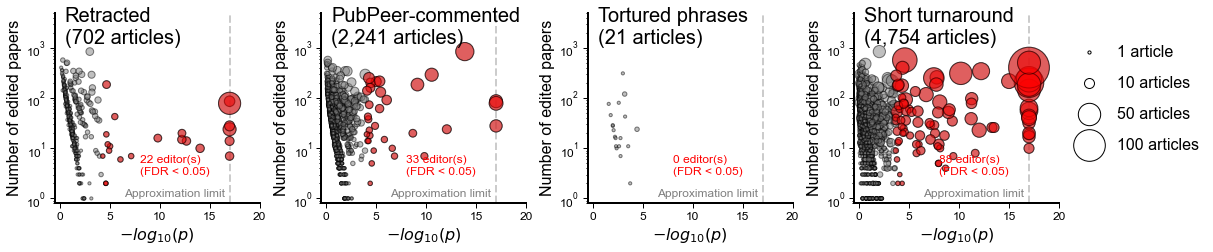

In [10]:
aff_df = []
type_df = []
date_df = []
contrib_df = []
subj_df = []

for n in list(range(1_000, 346_000, 1_000)) + [345_710]:
    contrib_df.append(pd.read_csv('../data/231109_plos_contributors_' + str(n) + '.csv'))
    type_df.append(pd.read_csv('../data/231109_plos_content_type_' + str(n) + '.csv'))
    date_df.append(pd.read_csv('../data/231109_plos_handling_time_' + str(n) + '.csv'))
    try:
        aff_df.append(pd.read_csv('../data/231109_plos_aff_' + str(n) + '.csv'))
    except:
        print('No aff_df at ' + str(n))
    subj_df.append(pd.read_csv('../data/231109_plos_subj_' + str(n) + '.csv'))

subj_df = pd.concat(subj_df).reset_index(drop=True)
contrib_df = pd.concat(contrib_df).reset_index(drop=True)
type_df = pd.concat(type_df).reset_index(drop=True)
date_df = pd.concat(date_df).reset_index(drop=True)
aff_df = pd.concat(aff_df).reset_index(drop=True)

type_df = type_df.drop_duplicates()

acceptable_types = ['Research Article', 'Review', 'Study Protocol', 
                    'Registered Report Protocol', 'Clinical Trial', 
                    'Lab Protocol', 'Collection Review']

type_df = type_df[type_df['content_type'].isin(acceptable_types)]
type_df['journal'] = type_df['doi'].apply(lambda x: x.split('.')[:-1][-1])
type_df = type_df[type_df['journal'] == 'pone']
accept_dois = type_df['doi'].values

contrib_df = contrib_df[contrib_df['doi'].isin(accept_dois)]
contrib_df = contrib_df.sort_values('orcid').drop_duplicates(subset=['doi', 'contrib', 'contrib_type', 'orcid'])
authors_df = contrib_df[contrib_df['contrib_type'] == 'author'].copy()
editors_df = contrib_df[contrib_df['contrib_type'].isin(['editor'])].copy()

editors_df = editors_df.drop_duplicates('doi', keep='first')[['doi', 'contrib', 'contrib_type']].rename(columns={'contrib':'full_name'})

authors_df['orcid'] = authors_df['orcid'].astype(str).apply(lambda x: x.split('/')[-1].strip())

date_df['date'] = pd.to_datetime(date_df['day'].astype(str) + '-' + date_df['month'].astype(str) + '-' + date_df['year'].astype(str), 
               dayfirst=True, errors='coerce')
date_df = date_df.sort_values('date').drop_duplicates(['doi', 'date_type'])\
.pivot(index='doi', columns='date_type', values='date').reset_index()
date_df['days'] = [x.days for x in (date_df['accepted'] - date_df['received'])]
date_df['year'] = [x.year for x in date_df['Published']]
short_time_dois = date_df[date_df['days'] <= 30]['doi'].values

master_authors_df = authors_df.copy()
master_authors_df['orcid'] = master_authors_df['orcid'].replace('nan', np.nan)
editors_df = pd.merge(editors_df, date_df[['doi', 'year']])
master_authors_df = pd.merge(master_authors_df, date_df[['doi', 'year']])

# Retractions
rw_db = pd.read_csv('../data/240304_retraction_watch_db.csv', encoding='latin')
a = rw_db[rw_db['RetractionNature'] == 'Retraction']['OriginalPaperDOI'].values
a = [str(x).lower() for x in a]
#a = rw_db['OriginalPaperDOI'].values

# Pubpeer
pubpeer_df = pd.read_csv('C:/Users/richa/OneDrive - Northwestern University/pubpeer_comments_20240201.csv')
pubpeer_df['id'] = pubpeer_df['ids'].astype(str).apply(lambda x: x.split(','))
pubpeer_df = pubpeer_df.explode('id')
pubpeer_df['paper_link'] = pubpeer_df['Pubpeer Link'].astype(str).apply(lambda x: '/'.join(x.split('/')[:-1])).values
b = pubpeer_df['id'].values

# Tortured Phrases
tort_df = pd.read_csv('../data/240321_tortured_phrases.csv')

editors_df['retracted'] = editors_df['doi'].isin(a)
editors_df['pubpeer'] = editors_df['doi'].isin(b)
editors_df['either'] = editors_df['retracted'] | editors_df['pubpeer']
editors_df['tortured'] = editors_df['doi'].isin(tort_df['DOI'].str.lower().values)
editors_df['short'] = editors_df['doi'].isin(short_time_dois)
editors_df['total'] = True


editors_df['full_name'] = editors_df['full_name'].str.replace('.', '').str.replace(' ', '').str.lower()

master_editors_df = editors_df.copy()

for source_id in ['pone']:
    editors_df = master_editors_df[master_editors_df['doi'].isin(accept_dois)]


    # In[17]:


    rate_df = editors_df.groupby('year').sum()[['retracted', 'pubpeer', 'either', 'tortured', 'short', 'total']]

    rate_df['p_retracted'] = rate_df['retracted']/rate_df['total']
    rate_df['p_pubpeer'] = rate_df['pubpeer']/rate_df['total']
    rate_df['p_tortured'] = rate_df['tortured']/rate_df['total']
    rate_df['p_either'] = rate_df['either']/rate_df['total']
    rate_df['p_short'] = rate_df['short']/rate_df['total']


    # In[18]:


    summary_by_editor = editors_df.groupby('full_name').sum()


    # In[19]:


    editor_year_list = editors_df.groupby('full_name')['year'].apply(list)

    #rate_dict = rate_df['p_retracted'].to_dict()
    p_val_array = []
    editor_list = []
    for editor, row in tqdm(pd.DataFrame(editor_year_list).iterrows(), total=len(editor_year_list)):
        year_list = row['year']
        
        # personalize rate_df
        rate_df = editors_df[editors_df['full_name'] != editor].groupby('year').sum()\
        [['retracted', 'pubpeer', 'either', 'tortured', 'short', 'total']]
        rate_df['p_retracted'] = rate_df['retracted']/rate_df['total']
        rate_df['p_pubpeer'] = rate_df['pubpeer']/rate_df['total']
        rate_df['p_tortured'] = rate_df['tortured']/rate_df['total']
        rate_df['p_either'] = rate_df['either']/rate_df['total']
        rate_df['p_short'] = rate_df['short']/rate_df['total']
        rate_dict = rate_df['p_retracted'].to_dict()
        
        p_array = [rate_dict.get(x) for x in year_list]
        p_val = PoiBin(p_array).pval(int(summary_by_editor.loc[editor]['retracted']))
        editor_list.append(editor)
        p_val_array.append(p_val)

    p_val_df = pd.DataFrame({'editor':editor_list, 'retract_p_val':p_val_array})

    #rate_dict = rate_df['p_pubpeer'].to_dict()
    p_val_array = []
    editor_list = []
    for editor, row in tqdm(pd.DataFrame(editor_year_list).iterrows(), total=len(editor_year_list)):
        year_list = row['year']
        
        # personalize rate_df
        rate_df = editors_df[editors_df['full_name'] != editor].groupby('year').sum()\
        [['retracted', 'pubpeer', 'either', 'tortured', 'short', 'total']]
        rate_df['p_retracted'] = rate_df['retracted']/rate_df['total']
        rate_df['p_pubpeer'] = rate_df['pubpeer']/rate_df['total']
        rate_df['p_tortured'] = rate_df['tortured']/rate_df['total']
        rate_df['p_either'] = rate_df['either']/rate_df['total']
        rate_df['p_short'] = rate_df['short']/rate_df['total']
        rate_dict = rate_df['p_pubpeer'].to_dict()
        
        p_array = [rate_dict.get(x) for x in year_list]
        p_val = PoiBin(p_array).pval(int(summary_by_editor.loc[editor]['pubpeer']))
        editor_list.append(editor)
        p_val_array.append(p_val)

    p_val_df['pubpeer_p_val'] = p_val_array

    #rate_dict = rate_df['p_either'].to_dict()
    p_val_array = []
    editor_list = []
    for editor, row in tqdm(pd.DataFrame(editor_year_list).iterrows(), total=len(editor_year_list)):
        year_list = row['year']
        
        # personalize rate_df
        rate_df = editors_df[editors_df['full_name'] != editor].groupby('year').sum()\
        [['retracted', 'pubpeer', 'either', 'tortured', 'short', 'total']]
        rate_df['p_retracted'] = rate_df['retracted']/rate_df['total']
        rate_df['p_pubpeer'] = rate_df['pubpeer']/rate_df['total']
        rate_df['p_tortured'] = rate_df['tortured']/rate_df['total']
        rate_df['p_either'] = rate_df['either']/rate_df['total']
        rate_df['p_short'] = rate_df['short']/rate_df['total']
        rate_dict = rate_df['p_either'].to_dict()
        
        p_array = [rate_dict.get(x) for x in year_list]
        p_val = PoiBin(p_array).pval(int(summary_by_editor.loc[editor]['either']))
        editor_list.append(editor)
        p_val_array.append(p_val)

    p_val_df['either_p_val'] = p_val_array
    
    #rate_dict = rate_df['p_tortured'].to_dict()
    p_val_array = []
    editor_list = []
    for editor, row in tqdm(pd.DataFrame(editor_year_list).iterrows(), total=len(editor_year_list)):
        year_list = row['year']
        
        # personalize rate_df
        rate_df = editors_df[editors_df['full_name'] != editor].groupby('year').sum()\
        [['retracted', 'pubpeer', 'either', 'tortured', 'short', 'total']]
        rate_df['p_retracted'] = rate_df['retracted']/rate_df['total']
        rate_df['p_pubpeer'] = rate_df['pubpeer']/rate_df['total']
        rate_df['p_tortured'] = rate_df['tortured']/rate_df['total']
        rate_df['p_either'] = rate_df['either']/rate_df['total']
        rate_df['p_short'] = rate_df['short']/rate_df['total']
        rate_dict = rate_df['p_tortured'].to_dict()
        
        p_array = [rate_dict.get(x) for x in year_list]
        p_val = PoiBin(p_array).pval(int(summary_by_editor.loc[editor]['tortured']))
        editor_list.append(editor)
        p_val_array.append(p_val)

    p_val_df['tortured_p_val'] = p_val_array

    rate_dict = rate_df['p_short'].to_dict()
    p_val_array = []
    editor_list = []
    for editor, row in tqdm(pd.DataFrame(editor_year_list).iterrows(), total=len(editor_year_list)):
        year_list = row['year']
        
        # personalize rate_df
        rate_df = editors_df[editors_df['full_name'] != editor].groupby('year').sum()\
        [['retracted', 'pubpeer', 'either', 'tortured', 'short', 'total']]
        rate_df['p_retracted'] = rate_df['retracted']/rate_df['total']
        rate_df['p_pubpeer'] = rate_df['pubpeer']/rate_df['total']
        rate_df['p_tortured'] = rate_df['tortured']/rate_df['total']
        rate_df['p_either'] = rate_df['either']/rate_df['total']
        rate_df['p_short'] = rate_df['short']/rate_df['total']
        rate_dict = rate_df['p_short'].to_dict()
        
        p_array = [rate_dict.get(x) for x in year_list]
        p_val = PoiBin(p_array).pval(int(summary_by_editor.loc[editor]['short']))
        editor_list.append(editor)
        p_val_array.append(p_val)

    p_val_df['short_p_val'] = p_val_array

    for col in ['retract_p_val', 'pubpeer_p_val', 'either_p_val', 'tortured_p_val', 'short_p_val']:
        p_val_df.loc[p_val_df[col] < 0, col] = 1e-17
        p_val_df[col.split('_')[0]+'_q_val'] = multipletests(p_val_df[col], method='fdr_bh')[1]
        p_val_df[col.split('_')[0]+'_fwer'] = multipletests(p_val_df[col], method='bonferroni')[1]

    p_val_df = pd.merge(p_val_df, summary_by_editor.reset_index().rename(columns={'full_name':'editor'}))

    fig, axes = plt.subplots(ncols=4, nrows=1, figsize=(18,3.5), gridspec_kw={'wspace':0.3})

    # Retractions
    ax = axes[0]
    ax.scatter(-np.log10(p_val_df['retract_p_val']), p_val_df['total'],
               color='gray', linewidth=1, alpha=0.5, s=10*p_val_df['retracted'], edgecolor='k')
    p_val_df_slice = p_val_df[p_val_df['retract_q_val'] < 0.05].copy()
    ax.scatter(-np.log10(p_val_df_slice['retract_p_val']), p_val_df_slice['total'], 
               color='r', linewidth=1, alpha=0.5, s=10*p_val_df_slice['retracted'], edgecolor='k')
    ax.set_title('Retracted\n(' + '{:,}'.format(editors_df['retracted'].sum()) + ' articles)', 
                 fontsize=20, ha='left', x=0.05, y=1.0, va='top')
    ax.text(s=str(len(p_val_df_slice)) + ' editor(s)\n(FDR < 0.05)', fontsize=12, y=3, x=8, color='r')

    # PubPeer
    ax = axes[1]
    ax.scatter(-np.log10(p_val_df['pubpeer_p_val']), p_val_df['total'],
               color='gray', linewidth=1, alpha=0.5, s=10*p_val_df['pubpeer'], edgecolor='k')
    p_val_df_slice = p_val_df[p_val_df['pubpeer_q_val'] < 0.05]
    ax.scatter(-np.log10(p_val_df_slice['pubpeer_p_val']), p_val_df_slice['total'], 
               color='r', linewidth=1, alpha=0.5, s=10*p_val_df_slice['pubpeer'], edgecolor='k')
    ax.set_title('PubPeer-commented\n(' + '{:,}'.format(editors_df['pubpeer'].sum()) + ' articles)', 
                 fontsize=20, ha='left', x=0.05, y=1.0, va='top')
    ax.text(s=str(len(p_val_df_slice)) + ' editor(s)\n(FDR < 0.05)', fontsize=12, y=3, x=8, color='r')

    # Tortured
    ax = axes[2]
    ax.scatter(-np.log10(p_val_df['tortured_p_val']), p_val_df['total'],
               color='gray', linewidth=1, alpha=0.5, s=10*p_val_df['tortured'], edgecolor='k')
    p_val_df_slice = p_val_df[p_val_df['tortured_q_val'] < 0.05]
    ax.scatter(-np.log10(p_val_df_slice['tortured_p_val']), p_val_df_slice['total'],
               color='r', linewidth=1, alpha=0.5, s=10*p_val_df_slice['tortured'], edgecolor='k')
    ax.set_title('Tortured phrases\n(' + '{:,}'.format(editors_df['tortured'].sum()) + ' articles)', 
                 fontsize=20, ha='left', x=0.05, y=1.0, va='top')
    ax.text(s=str(len(p_val_df_slice)) + ' editor(s)\n(FDR < 0.05)', fontsize=12, y=3, x=8, color='r')
    
    # Short
    ax = axes[3]
    ax.scatter(-np.log10(p_val_df['short_p_val']), p_val_df['total'],
               color='gray', linewidth=1, alpha=0.5, s=10*p_val_df['short'], edgecolor='k')
    p_val_df_slice = p_val_df[p_val_df['short_q_val'] < 0.05]
    ax.scatter(-np.log10(p_val_df_slice['short_p_val']), p_val_df_slice['total'],
               color='r', linewidth=1, alpha=0.5, s=10*p_val_df_slice['short'], edgecolor='k')
    ax.set_title('Short turnaround\n(' + '{:,}'.format(editors_df['short'].sum()) + ' articles)', 
                 fontsize=20, ha='left', x=0.05, y=1.0, va='top')
    ax.text(s=str(len(p_val_df_slice)) + ' editor(s)\n(FDR < 0.05)', fontsize=12, y=3, x=8, color='r')

    ax.scatter([], [], s=10, color='w', alpha=1, linewidth=1, edgecolor='k', label='1 article')
    ax.scatter([], [], s=100, color='w', alpha=1, linewidth=1, edgecolor='k', label='10 articles')
    ax.scatter([], [], s=500, color='w', alpha=1, linewidth=1, edgecolor='k', label='50 articles')
    ax.scatter([], [], s=1000, color='w', alpha=1, linewidth=1, edgecolor='k', label='100 articles')
    #ax.scatter([], [], s=2000, color='w', alpha=1, linewidth=1, edgecolor='k', label='200 retracted/commented')
    ax.legend(fontsize=16, bbox_to_anchor=(1,0.55), loc='center left', frameon=False, labelspacing=1, handletextpad=0.75)

    for ax in axes:
        ax.set_yscale('log')
        ax.set_xlabel(r'$-log_{10}(p)$', fontsize=16)
        ax.set_ylabel('Number of edited papers', fontsize=16)
        ax.set_ylim([0.8, 5000])
        ax.set_xlim([-0.5,20])
        ax.tick_params(width=1, length=5, which='major')
        ax.tick_params(width=1, length=2, which='minor')
        ax.tick_params(labelsize=12)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        [ax.spines[i].set_linewidth(2) for i in ax.spines]
        ax.axvline(17, color='k', linewidth=2, linestyle='dashed', alpha=0.2, zorder=-10)
        ax.text(s='Approximation limit', x=16.5, y=1, fontsize=12, va='bottom', ha='right', color='k', alpha=0.5)
    
    title = 'PLOS ONE'
        
    #fig.suptitle(title + ' (' + '{:,}'.format(len(editors_df)) + ' articles)', y=1.05, fontsize=20)
    #fig.savefig('../img/240405_' + source_id + '_p_value_axis_flip.png', dpi=200, bbox_inches='tight')
    p_val_df.to_csv('../data/240405_' + source_id + '_editor_p_values_alternate.csv', index=False)
    
    # author attributes
    authors_df = master_authors_df[master_authors_df['doi'].isin(editors_df['doi'])]
    
    print('{:.2f}'.format(100*authors_df['orcid'].isna().mean()) + '% of authors have no ORCID')
    print('{:.2f}'.format(100-(100*authors_df[~authors_df['orcid'].isna()]['doi'].nunique()/authors_df['doi'].nunique())) + '% of articles have no author ORCID')
    
    
    
    #### authors with preferences towards suspect editors
    for col in ['retract', 'pubpeer', 'either', 'tortured', 'short']:
        editors_df[col + '_suspect'] = editors_df['full_name'].isin(p_val_df[p_val_df[col + '_q_val'] < 0.05]['editor'])

    rate_df = editors_df.groupby('year').sum()[['retract_suspect', 'pubpeer_suspect', 'either_suspect', 'tortured_suspect', 'short_suspect', 'total']]

    rate_df['p_retract_suspect'] = rate_df['retract_suspect']/rate_df['total']
    rate_df['p_pubpeer_suspect'] = rate_df['pubpeer_suspect']/rate_df['total']
    rate_df['p_either_suspect'] = rate_df['either_suspect']/rate_df['total']
    rate_df['p_tortured_suspect'] = rate_df['tortured_suspect']/rate_df['total']
    rate_df['p_short_suspect'] = rate_df['short_suspect']/rate_df['total']

    ###### By ORCID ID
    summary_by_author = pd.merge(master_authors_df, editors_df, on='doi').dropna(subset=['orcid']).groupby('orcid').sum()

    author_year_list = authors_df.dropna(subset=['orcid']).groupby('orcid')['year'].apply(list)

    rate_dict = rate_df['p_retract_suspect'].to_dict()
    p_val_array = []
    author_list = []
    for author, row in tqdm(pd.DataFrame(author_year_list).iterrows(), total=len(author_year_list)):
        year_list = row['year']
        
        # personalize rate_df
        author_dois = authors_df[authors_df['orcid'] == author]['doi'].values
        rate_df = editors_df[~editors_df['doi'].isin(author_dois)].groupby('year').sum()[['retract_suspect', 'pubpeer_suspect', 'either_suspect', 'tortured_suspect', 'short_suspect', 'total']]

        rate_df['p_retract_suspect'] = rate_df['retract_suspect']/rate_df['total']
        rate_df['p_pubpeer_suspect'] = rate_df['pubpeer_suspect']/rate_df['total']
        rate_df['p_either_suspect'] = rate_df['either_suspect']/rate_df['total']
        rate_df['p_tortured_suspect'] = rate_df['tortured_suspect']/rate_df['total']
        rate_df['p_short_suspect'] = rate_df['short_suspect']/rate_df['total']
        rate_dict = rate_df['p_retract_suspect'].to_dict()
    
        p_array = [rate_dict.get(x) for x in year_list]
        p_val = PoiBin(p_array).pval(int(summary_by_author.loc[author]['retract_suspect']))
        author_list.append(author)
        p_val_array.append(p_val)

    author_p_val_df = pd.DataFrame({'author':author_list, 'retract_suspect_p_val':p_val_array})

    rate_dict = rate_df['p_pubpeer_suspect'].to_dict()
    p_val_array = []
    author_list = []
    for author, row in tqdm(pd.DataFrame(author_year_list).iterrows(), total=len(author_year_list)):
        year_list = row['year']
        
        # personalize rate_df
        author_dois = authors_df[authors_df['orcid'] == author]['doi'].values
        rate_df = editors_df[~editors_df['doi'].isin(author_dois)].groupby('year').sum()[['retract_suspect', 'pubpeer_suspect', 'either_suspect', 'tortured_suspect', 'short_suspect', 'total']]

        rate_df['p_retract_suspect'] = rate_df['retract_suspect']/rate_df['total']
        rate_df['p_pubpeer_suspect'] = rate_df['pubpeer_suspect']/rate_df['total']
        rate_df['p_either_suspect'] = rate_df['either_suspect']/rate_df['total']
        rate_df['p_tortured_suspect'] = rate_df['tortured_suspect']/rate_df['total']
        rate_df['p_short_suspect'] = rate_df['short_suspect']/rate_df['total']
        rate_dict = rate_df['p_pubpeer_suspect'].to_dict()
        
        p_array = [rate_dict.get(x) for x in year_list]
        p_val = PoiBin(p_array).pval(int(summary_by_author.loc[author]['pubpeer_suspect']))
        author_list.append(author)
        p_val_array.append(p_val)

    author_p_val_df['pubpeer_suspect_p_val'] = p_val_array

    rate_dict = rate_df['p_tortured_suspect'].to_dict()
    p_val_array = []
    author_list = []
    for author, row in tqdm(pd.DataFrame(author_year_list).iterrows(), total=len(author_year_list)):
        year_list = row['year']
        
        # personalize rate_df
        author_dois = authors_df[authors_df['orcid'] == author]['doi'].values
        rate_df = editors_df[~editors_df['doi'].isin(author_dois)].groupby('year').sum()[['retract_suspect', 'pubpeer_suspect', 'either_suspect', 'tortured_suspect', 'short_suspect', 'total']]

        rate_df['p_retract_suspect'] = rate_df['retract_suspect']/rate_df['total']
        rate_df['p_pubpeer_suspect'] = rate_df['pubpeer_suspect']/rate_df['total']
        rate_df['p_either_suspect'] = rate_df['either_suspect']/rate_df['total']
        rate_df['p_tortured_suspect'] = rate_df['tortured_suspect']/rate_df['total']
        rate_df['p_short_suspect'] = rate_df['short_suspect']/rate_df['total']
        rate_dict = rate_df['p_tortured_suspect'].to_dict()
        
        p_array = [rate_dict.get(x) for x in year_list]
        p_val = PoiBin(p_array).pval(int(summary_by_author.loc[author]['tortured_suspect']))
        author_list.append(author)
        p_val_array.append(p_val)

    author_p_val_df['tortured_suspect_p_val'] = p_val_array

    rate_dict = rate_df['p_short_suspect'].to_dict()
    p_val_array = []
    author_list = []
    for author, row in tqdm(pd.DataFrame(author_year_list).iterrows(), total=len(author_year_list)):
        year_list = row['year']
        
        # personalize rate_df
        author_dois = authors_df[authors_df['orcid'] == author]['doi'].values
        rate_df = editors_df[~editors_df['doi'].isin(author_dois)].groupby('year').sum()[['retract_suspect', 'pubpeer_suspect', 'either_suspect', 'tortured_suspect', 'short_suspect', 'total']]

        rate_df['p_retract_suspect'] = rate_df['retract_suspect']/rate_df['total']
        rate_df['p_pubpeer_suspect'] = rate_df['pubpeer_suspect']/rate_df['total']
        rate_df['p_either_suspect'] = rate_df['either_suspect']/rate_df['total']
        rate_df['p_tortured_suspect'] = rate_df['tortured_suspect']/rate_df['total']
        rate_df['p_short_suspect'] = rate_df['short_suspect']/rate_df['total']
        rate_dict = rate_df['p_short_suspect'].to_dict()
        
        p_array = [rate_dict.get(x) for x in year_list]
        p_val = PoiBin(p_array).pval(int(summary_by_author.loc[author]['short_suspect']))
        author_list.append(author)
        p_val_array.append(p_val)

    author_p_val_df['short_suspect_p_val'] = p_val_array

    rate_dict = rate_df['p_either_suspect'].to_dict()
    p_val_array = []
    editor_list = []
    for author, row in tqdm(pd.DataFrame(author_year_list).iterrows(), total=len(author_year_list)):
        year_list = row['year']
        
        # personalize rate_df
        author_dois = authors_df[authors_df['orcid'] == author]['doi'].values
        rate_df = editors_df[~editors_df['doi'].isin(author_dois)].groupby('year').sum()[['retract_suspect', 'pubpeer_suspect', 'either_suspect', 'tortured_suspect', 'short_suspect', 'total']]

        rate_df['p_retract_suspect'] = rate_df['retract_suspect']/rate_df['total']
        rate_df['p_pubpeer_suspect'] = rate_df['pubpeer_suspect']/rate_df['total']
        rate_df['p_either_suspect'] = rate_df['either_suspect']/rate_df['total']
        rate_df['p_tortured_suspect'] = rate_df['tortured_suspect']/rate_df['total']
        rate_df['p_short_suspect'] = rate_df['short_suspect']/rate_df['total']
        rate_dict = rate_df['p_either_suspect'].to_dict()
        
        p_array = [rate_dict.get(x) for x in year_list]
        p_val = PoiBin(p_array).pval(int(summary_by_author.loc[author]['either_suspect']))
        editor_list.append(editor)
        p_val_array.append(p_val)

    author_p_val_df['either_suspect_p_val'] = p_val_array

    for col in ['retract_suspect_p_val', 'pubpeer_suspect_p_val', 'either_suspect_p_val', 'tortured_suspect_p_val', 'short_suspect_p_val']:
        author_p_val_df.loc[author_p_val_df[col] < 0, col] = 1e-17
        author_p_val_df[col.split('_')[0]+'_' + col.split('_')[1] + '_q_val'] = multipletests(author_p_val_df[col], method='fdr_bh')[1]
        author_p_val_df[col.split('_')[0]+'_' + col.split('_')[1] + '_fwer'] = multipletests(author_p_val_df[col], method='bonferroni')[1]

    author_p_val_df = pd.merge(author_p_val_df, summary_by_author.reset_index().rename(columns={'orcid':'author'}))
    author_p_val_df.to_csv('../data/240405_' + source_id + '_author_orcid_p_values_fdr_alternate.csv', index=False)

# See compare_flagging_model ipynb (Figure S25)